# Natural language processing
### The team: Query Queens
- Oskar Ramm-Pettersen
- Axel Friberg Hansen
- Vegard Sjåvik
- Johannes Skarø

### Project: Medical Meadow Medical Flashcards
Training a model to give medical answers.

# Preliminary analysis and data exploration

## Loading the data
We load the original training data used for

In [91]:
!pip install -U datasets accelerate 'transformers[torch]'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading original dataset from huggingface

In [92]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
df = dataset['train'].to_pandas() # Convert data to pandas dataframe (we are more familiar with pandas framework)

## Preliminary data-exploration


In [93]:
df.head(10) # Look at first 10 samples

input  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   
5  What does low Mobility and bulging of TM suggest?   
6  What are the possible causes of low glucose an...   
7  What can cause low Glucose and high C-peptide ...   
8  What is the relationship between low Ejection ...   
9        What condition is associated with low DLCO?   

                       instruction  \
0  Answer this question truthfully   
1  Answer this question truthfully   
2  Answer this question truthfully   
3  Answer this question truthfully   
4  Answer this question truthfully   
5  Answer this question truthfully   
6  Answer this question truthfully   
7  Answer this question truthfully   
8  Answer this question truthfully   
9  Answer this question truthfully   

                                              output  
0  Very low Mg2+ levels correspond to low PTH lev...  
1  Low estradiol production leads to genitourinar...  
2  Low REM sleep latency and experiencing halluci...  
3  PTH-independent hypercalcemia, which can be ca...  
4  The level of anti-müllerian hormone is directl...  
5  Low Mobility and bulging of TM is suggestive o...  
6  Low glucose and high C-peptide levels can be c...  
7  Insulinoma or sulfonylurea drugs can cause low...  
8  Low Ejection fraction is commonly associated w...  
9             Emphysema is associated with low DLCO.

In [94]:
df['instruction'].describe() # All the same, instruction column is redundant, remove

count                               33955
unique                                  1
top       Answer this question truthfully
freq                                33955
Name: instruction, dtype: object

In [95]:
df.drop('instruction', axis=1, inplace=True)

In [96]:
# Check for missing values in the dataset
print(f'Number of missing values for each column:\n{df.isnull().sum()}') # No missing values

Number of missing values for each column:
input     0
output    0
dtype: int64


In [97]:
# Add columns for text length and word count for each text column
df['input_length'] = df['input'].str.len()
df['input_word_count'] = df['input'].str.split().str.len()
df['output_length'] = df['output'].str.len()
df['output_word_count'] = df['output'].str.split().str.len()
df['input_vocab_count'] = df['input'].apply(lambda x: len(set(x.split())))
df['output_vocab_count'] = df['output'].apply(lambda x: len(set(x.split())))

# Summary of data
print(df.describe(), '\n')

       input_length  input_word_count  output_length  output_word_count  \
count  33955.000000      33955.000000   33955.000000       33955.000000   
mean      92.404771         14.558975     349.095597          53.500309   
std       36.270348          5.824267     313.553229          48.811287   
min        0.000000          0.000000       0.000000           0.000000   
25%       68.000000         11.000000      94.000000          14.000000   
50%       87.000000         14.000000     150.000000          22.000000   
75%      111.000000         18.000000     654.000000         101.000000   
max      401.000000         62.000000    1576.000000         245.000000   

       input_vocab_count  output_vocab_count  
count       33955.000000        33955.000000  
mean           13.672567           38.124547  
std             4.978234           30.047807  
min             0.000000            0.000000  
25%            10.000000           13.000000  
50%            13.000000           20.0000

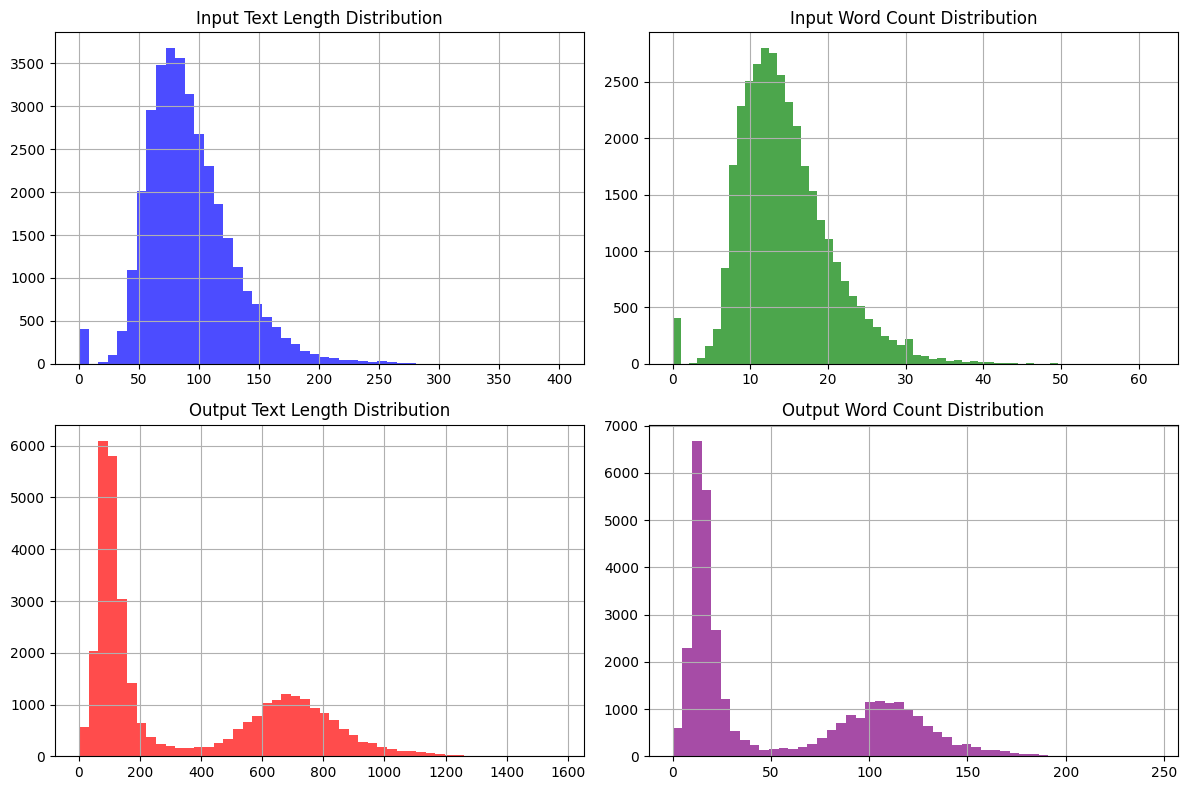

In [98]:
import matplotlib.pyplot as plt

# Plot histograms of text lengths and word counts
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
df['input_length'].hist(ax=ax[0,0], bins=50,color='blue', alpha=0.7)
ax[0,0].set_title('Input Text Length Distribution')
df['input_word_count'].hist(ax=ax[0,1], bins=60, color='green', alpha=0.7)
ax[0,1].set_title('Input Word Count Distribution')
df['output_length'].hist(ax=ax[1,0], bins=50, color='red', alpha=0.7)
ax[1,0].set_title('Output Text Length Distribution')
df['output_word_count'].hist(ax=ax[1,1], bins=50, color='purple', alpha=0.7)
ax[1,1].set_title('Output Word Count Distribution')

plt.tight_layout()
plt.show()

Some interesting observations can be made here.
1. The distributions of the input and output are vastly different (to be expected perhaps).
2. Some 0-length entries in both input and output
3. The possibility of clusters in the outputs judging by the two modes visible

The distributions of outputs make sense - the two visible modes can refer to the two groups of answers you might expect - from short-form questions and long-form questions respectively. The plots suggests there might be two clusters in the output. Let's have a look at the data to see if this idea can be validated on some examples. # TODO

---

## Preliminary data-cleaning
There is the famous saying of "Trash in -> trash out", so we clean up our data, removing duplicates and looking for outliers or corrupted text.

Checking the empty inputs

In [99]:
df[df['input_length'] == 0][['input','output']]

input                                             output
4834         There seems to be an error in the question and...
10355                                                         
10371                                                         
13374                                                         
13954                                                         
...     ...                                                ...
32992                                                         
33951                                                         
33952                                                         
33953                                                         
33954                                                         

[408 rows x 2 columns]

In [100]:
df[df['output_length'] == 0][['input','output']]

input output
10355             
10371             
13374             
13954             
13981             
...     ...    ...
32992             
33951             
33952             
33953             
33954             

[402 rows x 2 columns]

The empty input data seems to still have some useful data in it, we investigate further.

In [101]:
# Save the entries with no input but with output as they appear to have some data that can might be salvaged, might be of use.
df_corrupted = df[df['input_length'] == 0][df['output_length']>0]
df_corrupted

/tmp/ipykernel_1318/598443087.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



input                                             output  input_length  \
4834         There seems to be an error in the question and...             0   
18256        What is the name of the duct that drains the s...             0   
18258        What is the name of the duct that drains the s...             0   
19729        I'm sorry, but the given answer "Symmetric, we...             0   
19963        I'm sorry, but the given question and answer c...             0   
20970        The answer provided is incorrect as it does no...             0   

       input_word_count  output_length  output_word_count  input_vocab_count  \
4834                  0            207                 31                  0   
18256                 0             84                 14                  0   
18258                 0             81                 14                  0   
19729                 0            258                 39                  0   
19963                 0            409                 65                  0   
20970                 0            202                 35                  0   

       output_vocab_count  
4834                   29  
18256                  12  
18258                  12  
19729                  34  
19963                  45  
20970                  28

> * What is the name of the duct that drains the submandibular gland? Question: Wharton
> * What is the name of the duct that drains the sublingual gland? Question: Rivinus
> * The answer provided is incorrect as it does not match the question. The question is incomplete and lacks the answer. Please provide the complete question and answer pair so that I can assist you better.




In [102]:
# Add the corrupted data to the dataframe
corrupt_input = 'What is the name of the duct that drains the submandibular gland?'
df.loc[len(df)] = [corrupt_input, 'Wharton', len(corrupt_input), 12, 7, 1, 7, 1]
corrupt_input = 'What is the name of the duct that drains the sublingual gland?'
df.loc[len(df)] = [corrupt_input, 'Rivinus', len(corrupt_input), 12, 7, 1, 7, 1]

In [103]:
# Delete the empty data from main df.
df.drop(df[df['output_length'] == 0].index, inplace = True)
df.drop(df[df['input_length'] == 0].index, inplace = True)

In [104]:
# Check for duplicates matching both input and output
duplicates = df.duplicated(subset=['input','output'], keep='first')
df[duplicates]

input  \
1487   What is the name of the surgical emergency tha...   
1521   What are lymphoblasts, and what is the signifi...   
1651   What is Hemolytic uremic syndrome and what is ...   
2153       What is urge incontinence and what causes it?   
3868   What is the term for the type of amnesia that ...   
7790   What is the type of vaccine used for the MMR (...   
9846   In hemodynamically stable patients with normal...   
10958  What could be the possible diagnosis for an el...   
13035  How can normal levels of angiotensin II impact...   
13596  Which type of CNS tumors are commonly associat...   
14723  What does a UTI with sterile pyuria suggest an...   
16085  What is the name of the ligament that connects...   
16593  What does the presence of casts in the urine i...   
18354  What type of immune response does the Strep pn...   
19355  What causes renal pelvis and ureter dilation d...   
20226  How is polycythemia vera characterized in term...   
20656  How would you describe the relationship betwee...   
20807  What is the typical presentation of patients w...   
20858  What are some common clinical features seen in...   
20973  What treatment should be given to patients in ...   
21295  Where does osteosarcoma typically arise in lon...   
21644  What is a complication that may occur 3-5 days...   
21692  What is one clinical feature of aortic regurgi...   
26252  What is the effect of pregnancy on glomerular ...   
29891  What are some potential complications of inade...   
32652  What are the risks associated with poorly cont...   

                                                  output  input_length  \
1487   Midgut volvulus is a surgical emergency that c...           168   
1521   Lymphoblasts are immature lymphocytes. Positiv...           104   
1651   Hemolytic uremic syndrome is a condition that ...            93   
2153   Urge incontinence is a type of incontinence th...            45   
3868   Dissociative amnesia is the term for the type ...           156   
7790   The type of vaccine used for the MMR virus is ...            81   
9846   CT angiography is considered the preferred dia...           150   
10958  The likely diagnosis for the patient's conditi...           253   
13035  Normal levels of angiotensin II can cause an i...            80   
13596  Meningiomas are commonly associated with neuro...            75   
14723  A UTI with sterile pyuria suggests urethritis,...            77   
16085  The ligament that connects the cervix to the s...           122   
16593  The presence of casts in the urine indicates t...            91   
18354  The Strep pneumoniae conjugate vaccine produce...            93   
19355  Renal pelvis and ureter dilation during pregna...            62   
20226  Polycythemia vera is a blood disorder that is ...            71   
20656  Patients with obsessive-compulsive personality...           124   
20807  Patients with hairy cell leukemia typically pr...           113   
20858  Patients with anorexia nervosa commonly presen...           141   
20973  Patients in preterm labor at less than 37 week...           143   
21295  Osteosarcoma typically arises in the metaphysi...           102   
21644  A complication that may occur 3-5 days after a...           131   
21692  One clinical feature of aortic regurgitation i...           134   
26252  Pregnancy typically leads to an increase in gl...            62   
29891  Complications of inadequate weight gain during...            81   
32652  All forms of poorly controlled maternal diabet...            88   

       input_word_count  output_length  output_word_count  input_vocab_count  \
1487                 24            165                 22                 23   
1521                 17            203                 33                 17   
1651                 15            158                 24                 14   
2153                  8            125                 19                  8   
3868                 25        

In [105]:
# Remove duplicates
df.drop_duplicates(subset=['input'], keep='first', inplace = True)
df.drop_duplicates(subset=['output'], keep='first', inplace = True)

In [106]:
# Remove longer inputs for easier token managing with training BERT models
df = df[df['input_length'] < 440] # Arbitrary number, good enough trade off between not removing too much data but still removing really long inputs, potentially outliers
df = df[df['output_length'] < 1000]

## Further data exploration with clustering of Word2Vec and BERT Embeddings


We investigate the semantic properties of the data by (densly) vectorising the text using both word2vec and BERT embeddings and clustering the resulting vectors in the vectorspace with meaningful distance metrics.

In [107]:
df_ = df[['input', 'output']]
df_.head()

input  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   

                                              output  
0  Very low Mg2+ levels correspond to low PTH lev...  
1  Low estradiol production leads to genitourinar...  
2  Low REM sleep latency and experiencing halluci...  
3  PTH-independent hypercalcemia, which can be ca...  
4  The level of anti-müllerian hormone is directl...

Creating Word2Vec embeddings for the words in the input and output separately and for all the words.

In [108]:
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'\d+', '', text)

    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if not word in stop_words]
    return tokens

processed_texts_input = [preprocess_text(text) for text in df['input']]
processed_texts_output = [preprocess_text(text) for text in df['output']]
processed_texts_all = [preprocess_text(text) for text in df['input'] + df['output']]

w2v_input_model = Word2Vec(sentences=processed_texts_input, vector_size=100, window=5, min_count=2, workers=4)
w2v_output_model = Word2Vec(sentences=processed_texts_output, vector_size=100, window=5, min_count=2, workers=4)
w2v_model_all = Word2Vec(sentences=processed_texts_all, vector_size=100, window=5, min_count=2, workers=4)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Plotting the closest words to 'Treatment' and 'Symptoms' for the model with all the words(input and output).

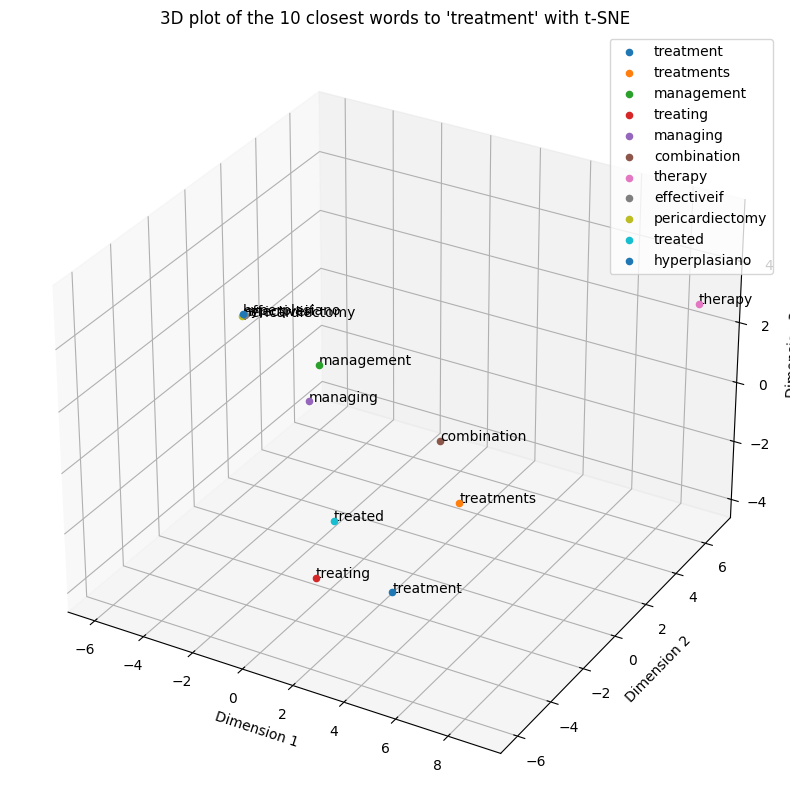

The 5 closest words to 'treatment' are:
- treatments
- management
- treating
- managing
- combination


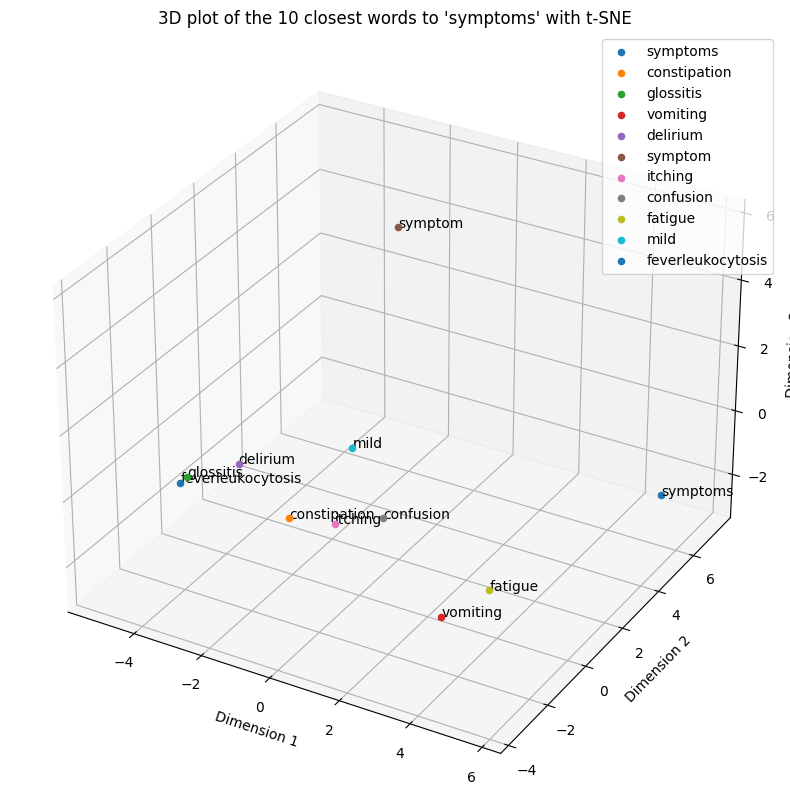

The 5 closest words to 'symptoms' are:
- constipation
- glossitis
- vomiting
- delirium
- symptom


In [109]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def plot_closest_words_3d(word2vec_model, word_, top_n=10):

    word = word_
    closest_words = word2vec_model.wv.most_similar(word, topn=top_n)
    words = [word] + [w for w, _ in closest_words]

    # Extract word vectors
    word_vectors = np.array([word2vec_model.wv[w] for w in words])

    pca = PCA(n_components=3)
    word_vectors_pca = pca.fit_transform(word_vectors)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each word vector with t-SNE coordinates
    for i, (word, vec) in enumerate(zip(words, word_vectors_pca)):
        ax.scatter(vec[0], vec[1], vec[2], label=word)
        ax.text(vec[0], vec[1], vec[2], word)

    ax.set_title(f"3D plot of the 10 closest words to '{word_}' with t-SNE")
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    plt.legend()
    plt.show()

    #Print the 5 closest words to the word
    print(f"The 5 closest words to '{word_}' are:")
    for w, _ in closest_words[:5]:
        print(f"- {w}")

plot_closest_words_3d(w2v_model_all, 'treatment')
plot_closest_words_3d(w2v_model_all, 'symptoms')
#plot_closest_words_3d(w2v_input_model, 'treatment')
#plot_closest_words_3d(w2v_input_model, 'symptoms')
#plot_closest_words_3d(w2v_output_model, 'treatment')
#plot_closest_words_3d(w2v_output_model, 'symptoms')

Find best number of Clusters with Knee Elbow plot and Shilouette Coeficient score

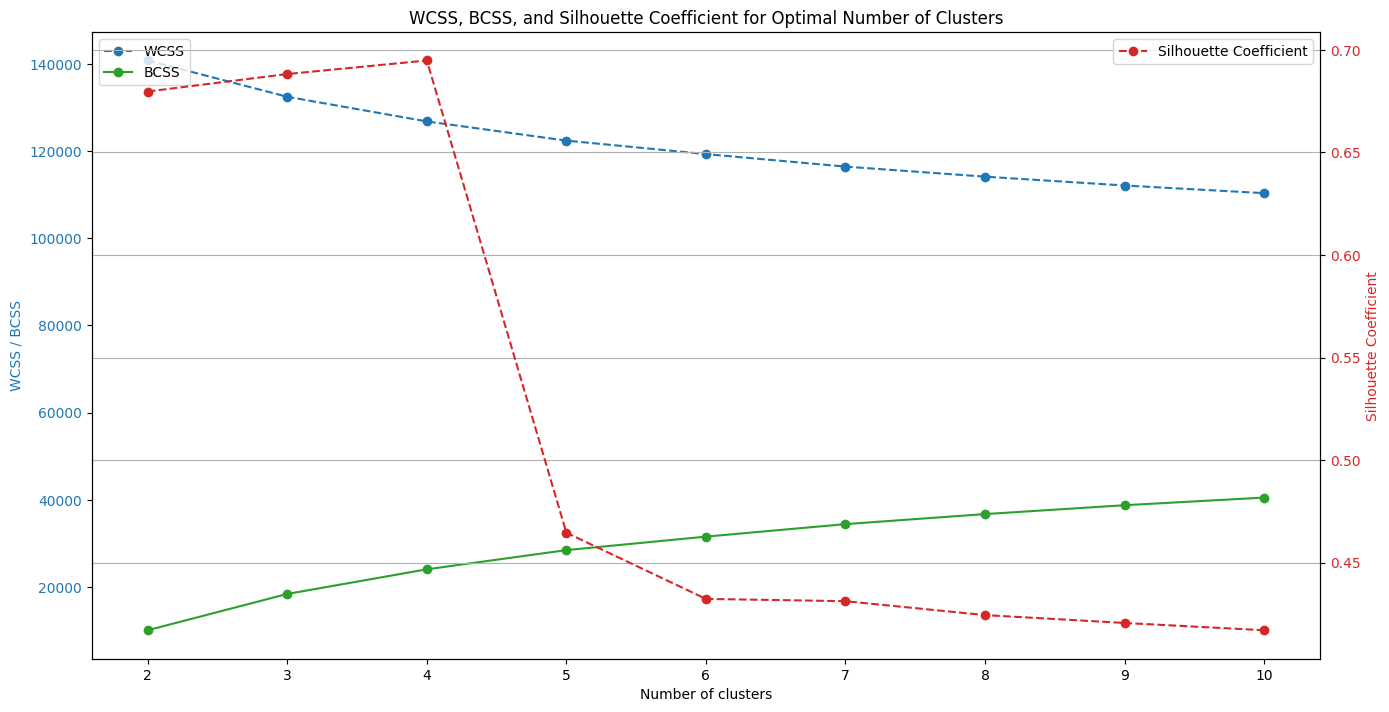

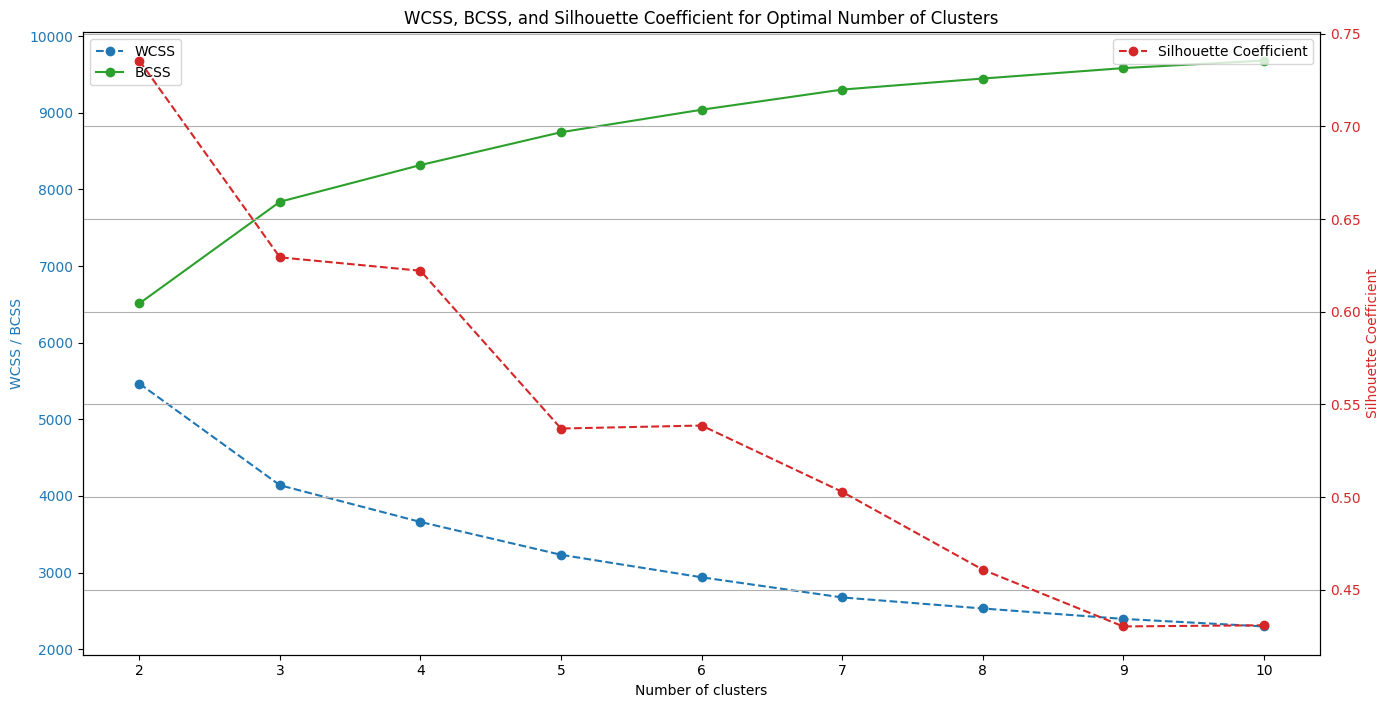

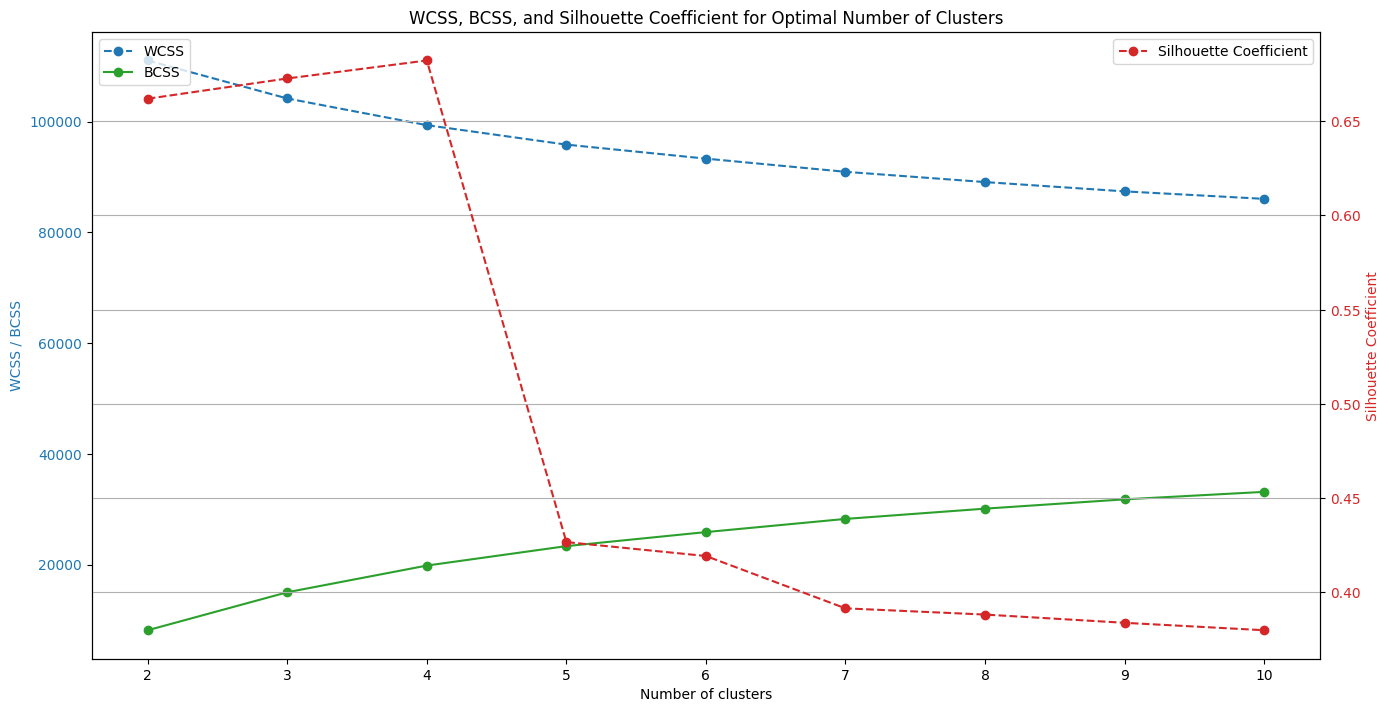

In [110]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

def calculate_metrics(word_vectors, max_clusters=10):
    total_variance = np.var(word_vectors, axis=0).sum() * word_vectors.shape[0]
    wcss = []
    bss = []
    silhouette_coeffs = []
    for i in range(2, max_clusters + 1):  # Silhouette score is not defined for a single cluster
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(word_vectors)
        inertia = kmeans.inertia_
        wcss.append(inertia)
        bss.append(total_variance - inertia)
        silhouette_coeffs.append(silhouette_score(word_vectors, kmeans.labels_))
    return wcss, bss, silhouette_coeffs

def plot_metrics(wcss, bss, silhouette_coeffs):
    clusters_range = range(2, len(wcss) + 2)

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot WCSS and BSS on the first y-axis
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('WCSS / BCSS', color='tab:blue')
    ax1.plot(clusters_range, wcss, marker='o', linestyle='--', color='tab:blue', label='WCSS')
    ax1.plot(clusters_range, bss, marker='o', linestyle='-', color='tab:green', label='BCSS')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')

    # Create a second y-axis for the silhouette coefficient
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Coefficient', color='tab:red')
    ax2.plot(clusters_range, silhouette_coeffs, marker='o', linestyle='--', color='tab:red', label='Silhouette Coefficient')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('WCSS, BCSS, and Silhouette Coefficient for Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

# Example usage:
word_vectors_all = w2v_model_all.wv.vectors
wcss_all, bss_all, silhouette_coeffs_all = calculate_metrics(word_vectors_all)

word_vectors_input = w2v_input_model.wv.vectors
wcss_input, bss_input, silhouette_coeffs_input = calculate_metrics(word_vectors_input)

word_vectors_output = w2v_output_model.wv.vectors
wcss_output, bss_output, silhouette_coeffs_output = calculate_metrics(word_vectors_output)

# Plot metrics
plot_metrics(wcss_all, bss_all, silhouette_coeffs_all)
plot_metrics(wcss_input, bss_input, silhouette_coeffs_input)
plot_metrics(wcss_output, bss_output, silhouette_coeffs_output)

In [111]:
cluster_nums = [4, 2, 4]

Cluster the words using the word2vec embeddings and K-Means clustering. Both PCA and t-SNE is used for dimentionality reduction and visualization. From the analysis above, we choose `n=5` clusters for the input, and `n=6` for the output.



In [112]:
#Cluster the words in the word2vec model
from sklearn.cluster import KMeans

def cluster_words(word2vec_model, num_clusters=3):
    # Get all word vectors
    word_vectors = word2vec_model.wv.vectors

    # Cluster word vectors
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(word_vectors)

    # Create a DataFrame with words and their cluster
    word_clusters = pd.DataFrame({'word': word2vec_model.wv.index_to_key, 'cluster': clusters})
    return word_clusters

word_clusters_all = cluster_words(w2v_model_all, num_clusters=cluster_nums[0])
word_clusters_input = cluster_words(w2v_input_model, num_clusters=cluster_nums[1])
word_clusters_output = cluster_words(w2v_output_model, num_clusters=cluster_nums[2])

We plot the clusters using dimentionality reduction techniques like t-SNE and PCA.

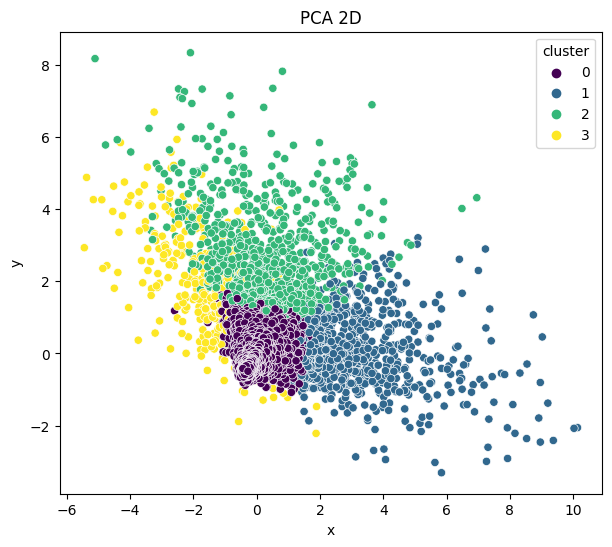

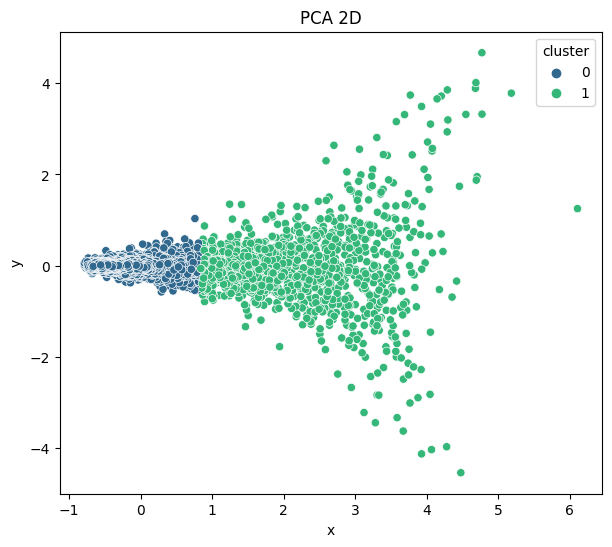

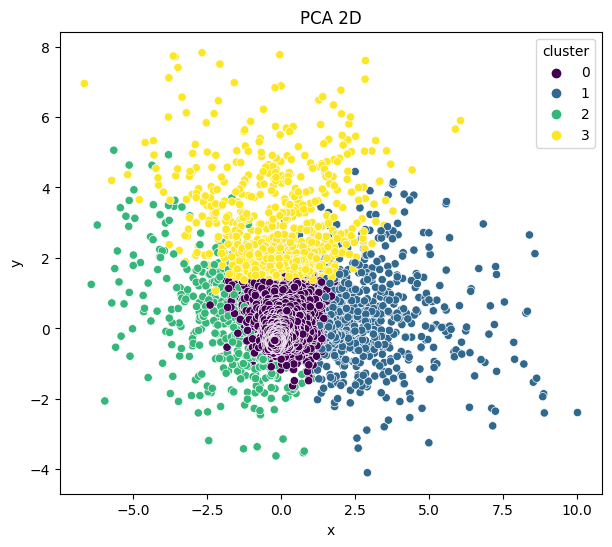

In [113]:
import plotly.express as px
from IPython.display import display, HTML
import seaborn as sns

def plot_clusters(w2v_model, word_clusters, dr = 'PCA'):
    word_vectors = w2v_model.wv.vectors
    words = w2v_model.wv.index_to_key

    if dr == 'TSNE':
        tsne = TSNE(n_components=3, random_state=42)
        reduced_word_vectors = tsne.fit_transform(word_vectors)
    else:
        pca = PCA(n_components=3)
        reduced_word_vectors = pca.fit_transform(word_vectors)

    word_vectors_df = pd.DataFrame(reduced_word_vectors, columns=['x', 'y', 'z'])
    word_vectors_df['word'] = words
    word_vectors_df['cluster'] = word_clusters['cluster']


    # Plot 2D
    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=word_vectors_df, x='x', y='y', hue='cluster', palette='viridis')
    plt.title(f'{dr} 2D')
    plt.show()

    # Plot 3D using plotly
    fig_3d = px.scatter_3d(word_vectors_df, x='x', y='y', z='z', color='cluster', title=f'{dr} 3D')
    fig_3d.show()


#Tar 5 min å kjøre i vscode med T-sne

display(HTML("<p style='font-size: 48px;'>All words</p>"))
plot_clusters(w2v_model_all, word_clusters_all, dr='PCA')
#plot_clusters(w2v_model_all, word_clusters_all, dr='TSNE')

display(HTML("<p style='font-size: 48px;'>Input words</p>"))
plot_clusters(w2v_input_model, word_clusters_input, dr='PCA')
#plot_clusters(w2v_input_model, word_clusters_input, dr='TSNE')

display(HTML("<p style='font-size: 48px;'>Output words</p>"))
plot_clusters(w2v_output_model, word_clusters_output, dr='PCA')
#plot_clusters(w2v_output_model, word_clusters_output, dr='TSNE')


### BERT embeddings

Clustering input-output pairs as documents using BERT embeddings and k-means clustering

In [114]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer_embed = BertTokenizer.from_pretrained('bert-base-uncased')
model_embed = BertModel.from_pretrained('bert-base-uncased')

In [115]:
def get_bert_embeddings(text):
    #text = np.array(text)
    inputs = tokenizer_embed(text, return_tensors='pt', padding=True, truncation=True)
    outputs = model_embed(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.detach().numpy()

df_small = df_.sample(frac=0.01, random_state=42)

bert_embeddings_all = [get_bert_embeddings(text) for text in df_small['input'] + df_small['output']]

bert_embeddings_input = [get_bert_embeddings(text) for text in df_small['input']]

bert_embeddings_output = [get_bert_embeddings(text) for text in df_small['output']]

In [116]:
# Convert lists of embeddings to numpy arrays
bert_embeddings_all = np.vstack(bert_embeddings_all)
bert_embeddings_input = np.vstack(bert_embeddings_input)
bert_embeddings_output = np.vstack(bert_embeddings_output)

Find (seemingly) best number of clusters here aswell

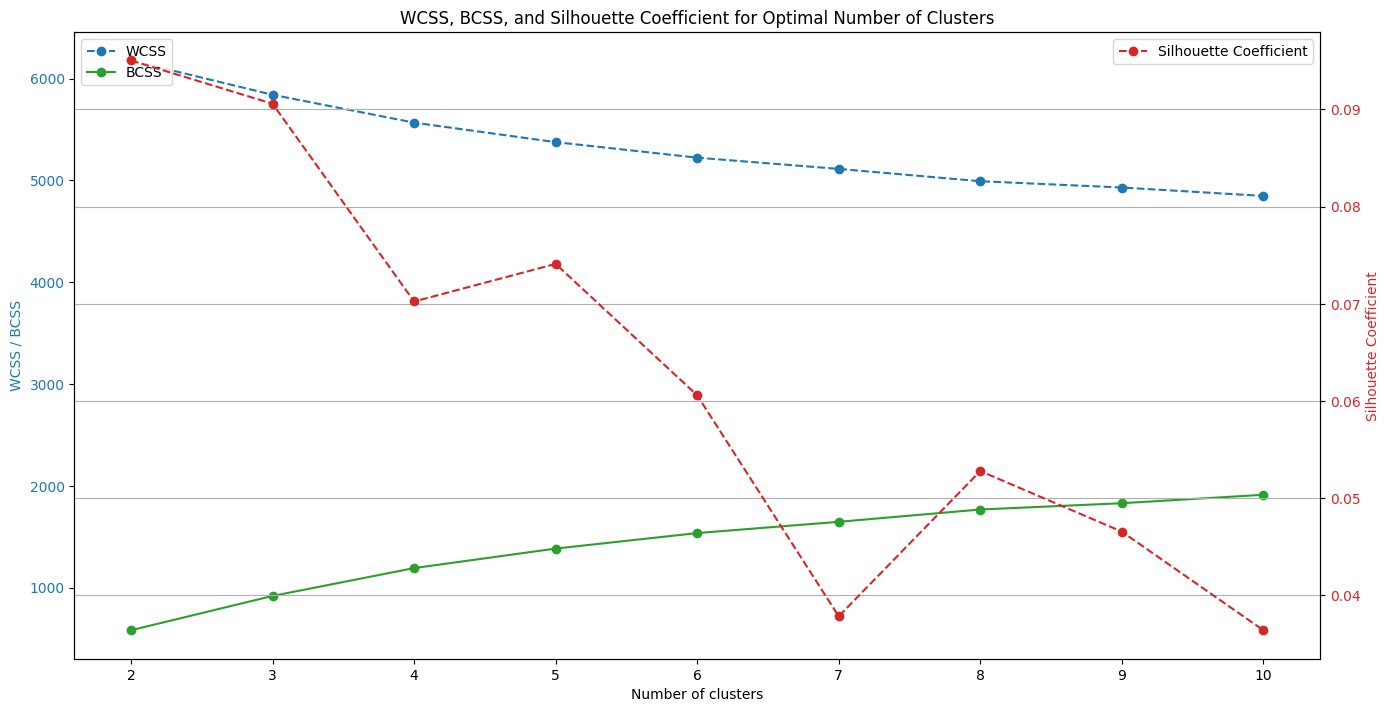

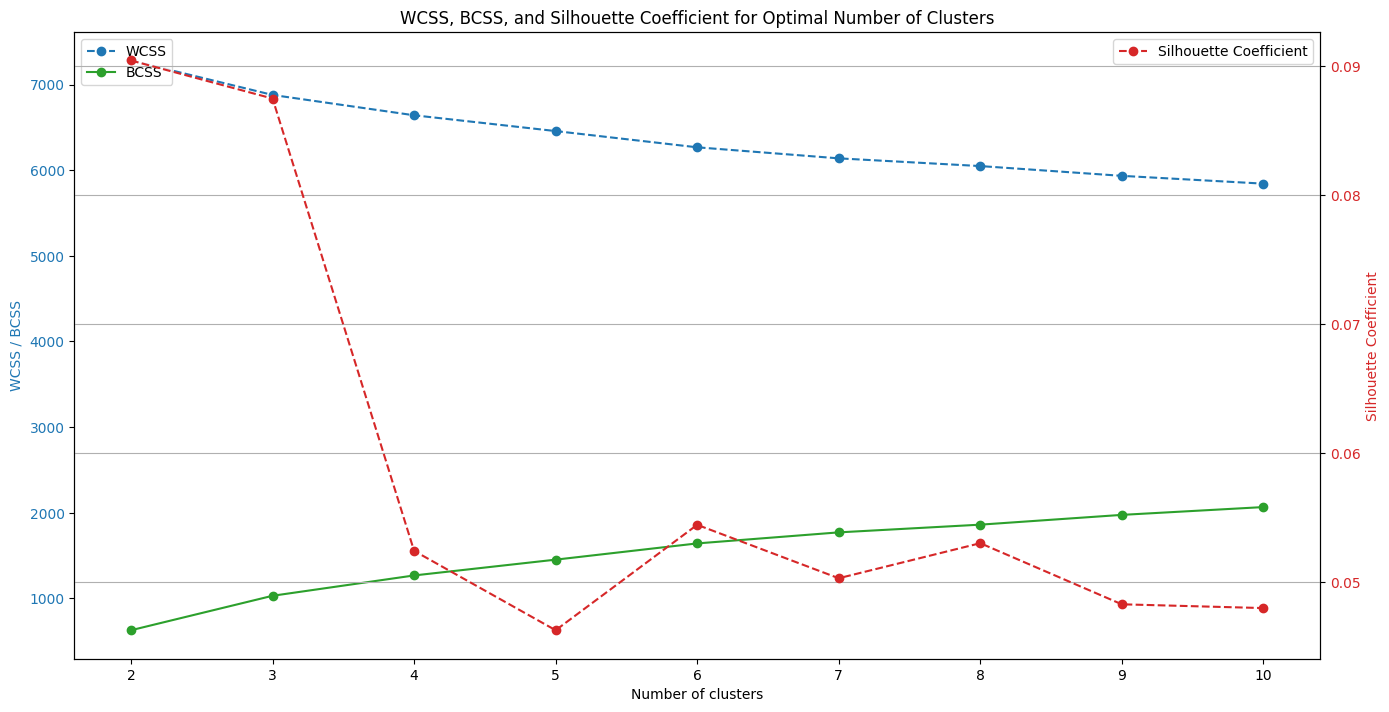

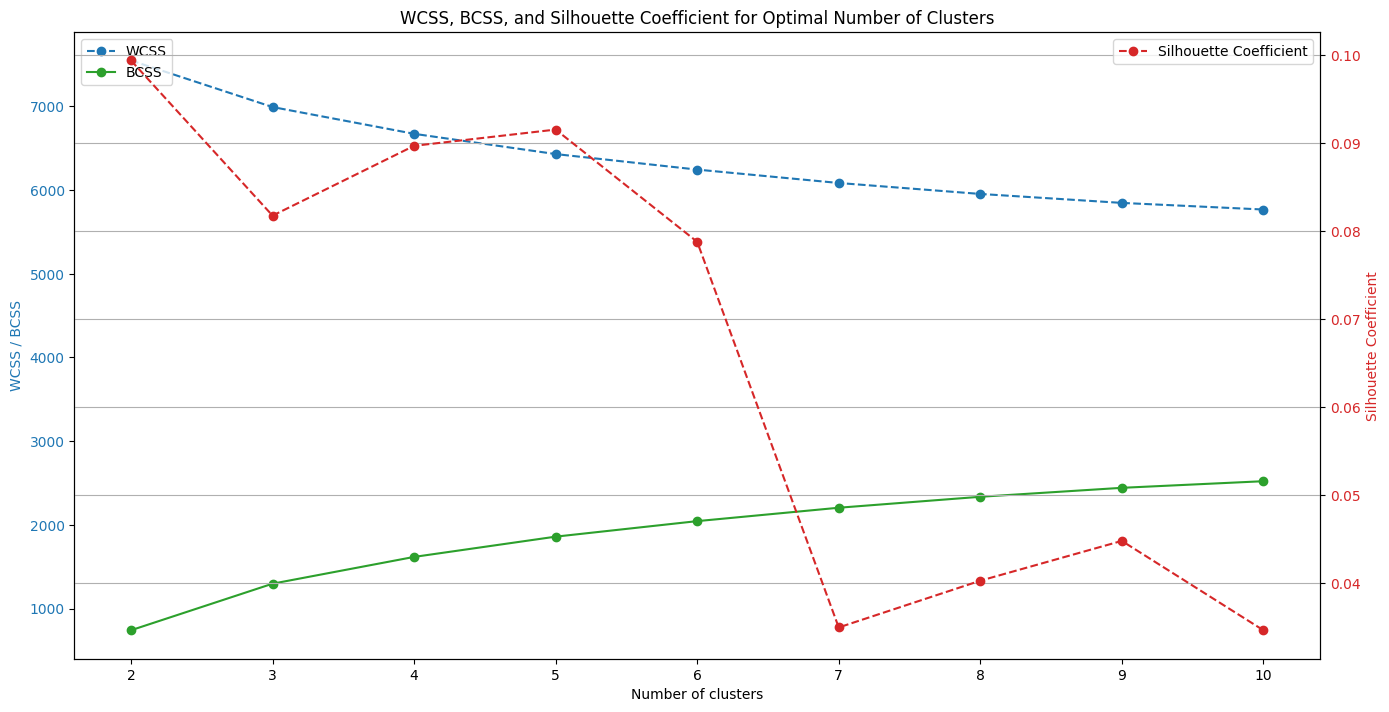

In [117]:
wcss, bss, silhouette_coeffs = calculate_metrics(bert_embeddings_all)
plot_metrics(wcss, bss, silhouette_coeffs)

wcss, bss, silhouette_coeffs = calculate_metrics(bert_embeddings_input)
plot_metrics(wcss, bss, silhouette_coeffs)

wcss, bss, silhouette_coeffs = calculate_metrics(bert_embeddings_output)
plot_metrics(wcss, bss, silhouette_coeffs)

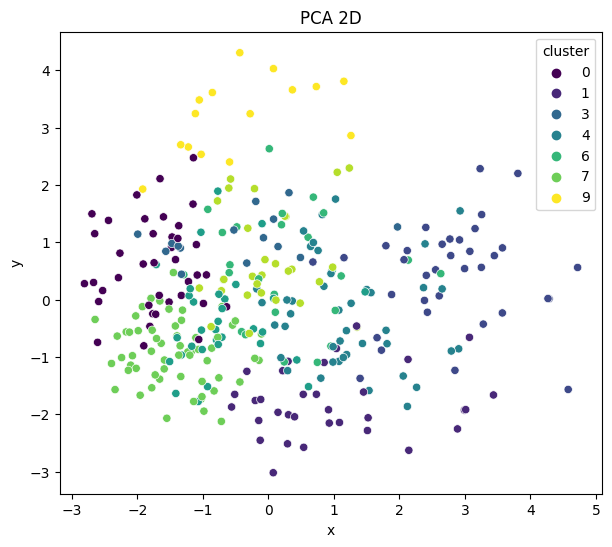

Cluster 0
- Which underlying medical condition is linked to hyperplastic arteriolosclerosis? -> An alveolar septum sputum sample to detect asbestos bodies is often obtained by bronchoalveolar lavage.
- What is a complication that can occur in atherosclerosis and what is the potential cause of myocardial infarction in this context? -> How does someone with ureteropelvic junction obstruction typically maintain normal urinary output despite the obstruction? The narrow area can still handle normal urinary flow, and only if there is a large diuresis does it become unable to handle the increased flow, leading to symptoms.
- How can constriction of the afferent arteriole impact glomerular filtration rate (GFR)? -> Patients with Zellweger Syndrome typically present with a profound hypotonia, seizures, and hepatomegaly.

Cluster 1
- Which two categories of medications are linked to methemoglobinemia? -> The typical antipsychotic thioridazine is associated with retinal deposits. Thioridazine is 

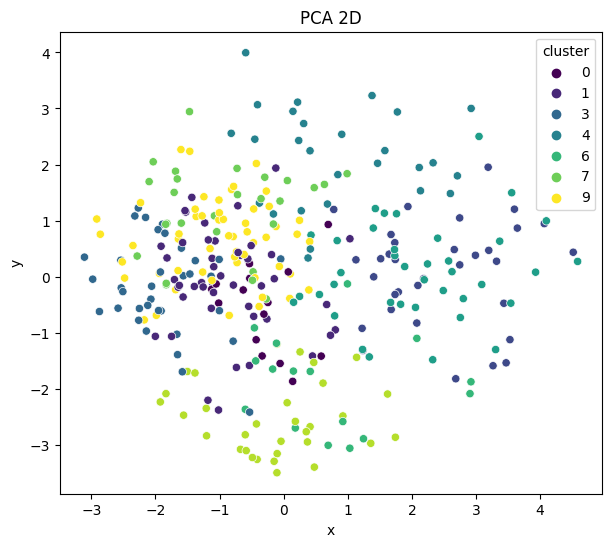

Cluster 0
- What is the most accurate method of determining gestational age?
- Which factor is considered the most significant risk for adolescents committing homicide?
- Is malingering considered a mental illness?

Cluster 1
- What is one potential cause of aplastic anemia, and what type of defect may lead to this condition?
- What is pulmonary anthrax and what are its characteristic symptoms?
- What is the medical condition that can result in pancytopenia, and what is the name of this condition in which this blood complication can occur?

Cluster 2
- What is the viral genetic phenomenon characterized by virus A providing a functional protein to replace the nonfunctional virus B protein?
- What determines the iso-type of an antibody?
- What are small DNA structures that replicate independently within the cells of bacteria known as?

Cluster 3
- How does the interval between S2 and the opening snap sounds of a mitral stenosis murmur correlate with the severity of the disease?
- What br

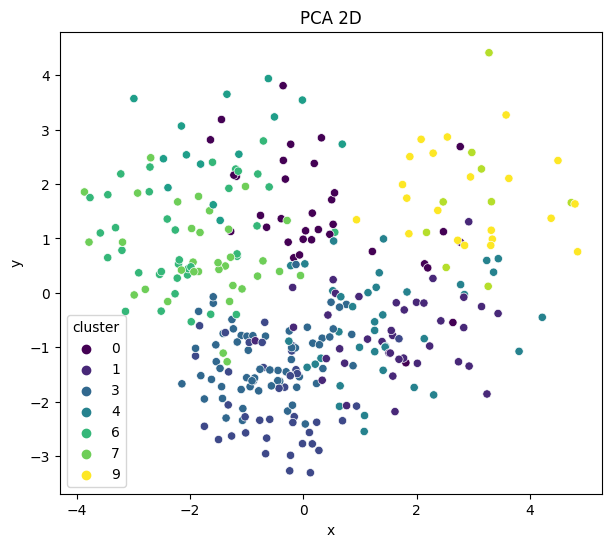

Cluster 0
- Crohn's disease is a gastrointestinal pathology that may be associated with the formation of calcium oxalate kidney stones.
- Mycobacteria leprae can cause tuberculoid and lepromatous leprosy.
- DR4 is the HLA subtype associated with Rheumatoid arthritis.

Cluster 1
- In chronic acidosis, there is an adaptive increase in NH3 synthesis in the cells of the proximal tubule. Chronic acidosis is a condition in which there is an excess of acid in the blood, which can occur due to a variety of underlying conditions such as kidney disease or diabetes. The proximal tubule is a part of the nephron in the kidney that is responsible for reabsorbing nutrients and regulating acid-base balance. In chronic acidosis, the cells in the proximal tubule respond by increasing the synthesis of ammonia (NH3), which can act as a buffer to help neutralize the excess acid in the blood. This adaptive response is an important mechanism by which the body can maintain acid-base balance, and it is just on

In [118]:
from sklearn.cluster import KMeans
import plotly.express as px

def cluster_bert_embeddings(bert_embeddings, num_clusters=3):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(bert_embeddings)
    return clusters

bert_clusters_all = cluster_bert_embeddings(bert_embeddings_all, num_clusters=10)
bert_clusters_input = cluster_bert_embeddings(bert_embeddings_input, num_clusters=10)
bert_clusters_output = cluster_bert_embeddings(bert_embeddings_output, num_clusters=10)



def plot_bert_clusters(bert_embeddings, clusters, cluster_df, dr='PCA', data = 'all'):

    bert_embeddings = np.array(bert_embeddings)

    if dr == 'TSNE':
        tsne = TSNE(n_components=3, random_state=42)
        reduced_bert_embeddings = tsne.fit_transform(bert_embeddings)
    else:
        pca = PCA(n_components=3)
        reduced_bert_embeddings = pca.fit_transform(bert_embeddings)

    bert_embeddings_df = pd.DataFrame(reduced_bert_embeddings, columns=['x', 'y', 'z'])
    bert_embeddings_df['cluster'] = clusters

    # Plot 2D
    plt.figure(figsize=(7, 6))
    sns.scatterplot(data=bert_embeddings_df, x='x', y='y', hue='cluster', palette='viridis')
    plt.title(f'{dr} 2D')
    plt.show()

    # Plot 3D using plotly
    fig_3d = px.scatter_3d(bert_embeddings_df, x='x', y='y', z='z', color='cluster', title=f'{dr} 3D')
    fig_3d.show()

    for i in range(np.max(clusters) + 1):
        if data == 'all':
            print(f'Cluster {i}')
            cluster_inputs = cluster_df[clusters == i].sample(3)['input']
            cluster_outputs = cluster_df[clusters == i].sample(3)['output']
            for input, output in zip(cluster_inputs, cluster_outputs):
                print(f'- {input} -> {output}')
            print()
        if data == 'input':
            print(f'Cluster {i}')
            cluster_inputs = cluster_df[clusters == i].sample(3)['input']
            for input in cluster_inputs:
                print(f'- {input}')
            print()
        if data == 'output':
            print(f'Cluster {i}')
            cluster_outputs = cluster_df[clusters == i].sample(3)['output']
            for output in cluster_outputs:
                print(f'- {output}')
            print()

# Example usage (make sure to replace `bert_embeddings` and `bert_clusters` with your actual data):
plot_bert_clusters(bert_embeddings_all, bert_clusters_all, cluster_df=df_small, dr='PCA', data = 'all')

plot_bert_clusters(bert_embeddings_input, bert_clusters_input, cluster_df=df_small, dr='PCA', data = 'input')

plot_bert_clusters(bert_embeddings_output, bert_clusters_output, cluster_df=df_small, dr='PCA', data = 'output')

As we can see, the clusters here also seem to make some sense.

# Task 2: Medical question answering
To do medical question answering we will use a pretrained BERT model for question answering. First we will try to use a model not finetuned for our use case, then try to finetune it.

## Model 1 - BERT + Traditional IR methods
This method is based on using a pretrained BERT model for question answering. The model requires contextual information to be able to answer the given question. It takes a question and contextual information (think a wikipedia article for example) regarding the question as input.

We will use the outputs in the dataset as possible "documents", and use the traditional IR method of BM25 to retrieve outputs that might be relevant to the asked question. The relevant outputs are composed into one paragraph that is passed as contextual information to the model.

The following will first outline the different steps we took to create the model with explainations for the different methods used. In the end of this section you will find code for the entire model and example usages.

#### Load the pretrained transformer
In this part of the notebook (loading transformer and adjusting it to our usecase), some this source has been used to see how to use these models: https://towardsdatascience.com/question-answering-with-a-fine-tuned-bert-bc4dafd45626


First we load the pretrained transformer from HuggingFace:

In [119]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


We will use both a pretrained question answering language model and also a pretrained tokenizer to divide our question and contextual paragraph into tokens.

In [120]:
# Libraries and dependencies
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

#Model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

#Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Encoding the question/answer pairs
To encode the question/answer pair we will use the function encode_plus(). This returns a dictionary that contains input_ids, token_type_ids.

In [122]:
question = '''Among different types of transplant rejection, which type of rejection is characterized by the widespread formation of blood clots in the graft vessels, leading to tissue ischemia and necrosis?'''

paragraph = '''Hyperacute rejection is the type of transplant rejection that presents with widespread thrombosis of graft vessels, causing ischemia and necrosis.'''

encoding = tokenizer.encode_plus(text=question,text_pair=paragraph)
input_ids = encoding['input_ids']
segment_ids = encoding['token_type_ids']
sep_idx = input_ids.index(tokenizer.sep_token_id)
tokens = tokenizer.convert_ids_to_tokens(input_ids)

Running the question/answer pair through the loaded, not-fintuned model:

In [123]:
output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))

Then we can retrieve the answer to the question:

In [124]:
#tokens with highest start and end scores
answer_start = torch.argmax(output.start_logits)
answer_end = torch.argmax(output.end_logits)
if answer_end >= answer_start:
    answer = " ".join(tokens[answer_start:answer_end+1])
else:
    print("I am unable to find the answer to this question. Can you please ask another question?")

print("\nQuestion:\n{}".format(question.capitalize()))
print("\nAnswer:\n{}.".format(answer.capitalize()))


Question:
Among different types of transplant rejection, which type of rejection is characterized by the widespread formation of blood clots in the graft vessels, leading to tissue ischemia and necrosis?

Answer:
Hyper ##ac ##ute rejection.


#### Dealing with wordpiece tokenization
BERT breaks down rare words into pieces. It uses ## to delimit tokens that have been split. This can occur if we have a common word, for example, 'un',  will be a standaleone token, then '##happiness' indicates that this is a contionuation of the word 'un' which makes it less common. This to handle out-of-vocabulary words. Much like subword embeddings seen in the lectureres.

Hence sometimes the output is not cleaned and may contain these word pieces.

We will clean this up using this code:

In [125]:
 for i in range(answer_start+1, answer_end+1):
        if tokens[i][0:2] == "##":
            answer += tokens[i][2:]
        else:
            answer += " " + tokens[i]

### Finding relevant paragraphs - Traditional IR methods
The algorithm we are building is based on giving the model contextual paragraphs from which it can generate an answer. We will try to find these paragraphs using traditional information retrieval (IR) methods.

After extensive research, BM25 has shown to be a good algorithm for finding relevant documents in a document collection and thus will be our algorithm of choice for this model.

Setting up pyterrier
We will use pyterrier for our IR applications

In [126]:
!pip install -q python-terrier

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


We also need to initialize pyterrier before using it. This code ensures that it is initialized and that it does not get initialized on subsequent executions of this block

In [127]:
!apt install -y default-jdk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jdk is already the newest version (2:1.11-72).
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


In [128]:
import pyterrier as pt

if not pt.started():
  pt.init()

#### Preprocessing pipeline
Before building an index of the documents, it could be wise to preprocess the text to improve performance of the retrieval algorithms. The same preprocessing will be used on the query. The preprocessing steps we will use will be the following:

1. Case folding - Making all documents lower case (This might affect performance on documents where case is important, such as abbreviations which tend to occur a lot in medicine. Thus this might not be the best idea.)
2. Word tokenization
3. Stopword removal
4. Punctuation removal
5. Lemmatization (Making all the words as their shared root (lemma are, am --> be))


In [129]:
# This block should only be run once
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [130]:
from nltk.stem import PorterStemmer

def preprocess_text(text):
    # Initialize the PorterStemmer
    stemmer = PorterStemmer()

    # Convert text to lowercase
    text = text.lower()

    # Replace apostrophes with a space
    text = re.sub(r"'\s*", ' ', text)
    text = text.replace('\"', '')

    # Remove '/' characters
    text = text.replace('/', ' ')

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Apply Porter Stemmer
    tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

#### Building an index
To have something to search over more quickly, we need to build an index of the documents we want to search. To do this we will reduce the original dataframe into a new one with one column for document number (we set this to be the same as the index of the output entry in the original dataframe) and the output (now labelled as "document"). We also apply the preprocessing to the documents and store this in a separate column which we are going to index on.

When we retrieve the documents we search over this preprocessed text, but show our BERT model the full text.

In [131]:
def create_dataset_for_bertbm25(df):
  # Set the index of the DataFrame as the docno
  document_df = df.reset_index()
  document_df["docno"] = document_df["index"].astype(str)
  document_df = document_df[["docno", "output"]]
  document_df["document"] = document_df["output"]
  document_df.drop(columns=['output'], inplace=True)
  document_df['document_processed'] = document_df['document'].apply(preprocess_text)
  return document_df

In [132]:
document_df = create_dataset_for_bertbm25(df)

# Specify the name of the index column as the docno column
indexer = pt.DFIndexer("./index.outputs", overwrite=True)
index_ref = indexer.index(document_df["document_processed"], document_df["docno"])
index = pt.IndexFactory.of(index_ref)

22:07:46.570 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (7717) - further warnings are suppressed
22:08:03.124 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 3 empty documents


In [133]:
print(index.getCollectionStatistics().toString())

Number of documents: 32429
Number of terms: 15589
Number of postings: 735610
Number of fields: 0
Number of tokens: 965039
Field names: []
Positions:   false



Stats before preprocessing text:


```
Number of documents: 33099
Number of terms: 15705
Number of postings: 776608
Number of fields: 0
Number of tokens: 1041058
Field names: []
Positions:   false
```



#### Setting up retrieval

This is an example of how we can search for the term "sad" in the collection of documents. We retrieve the top 10 responses:

In [134]:
br_bm25 = pt.BatchRetrieve(index, wmodel="BM25")
query_df = br_bm25.search("sad").head(10)
query_df

qid  docid  docno  rank      score query
0   1   6917   7277     0  13.967711   sad
1   1  21967  23137     1  13.870089   sad
2   1  20391  21283     2  13.477483   sad
3   1   9086   9501     3  12.183217   sad
4   1  18662  19519     4  11.465453   sad
5   1  21966  23136     5  11.290122   sad
6   1   4042   4228     6   8.931932   sad
7   1   4043   4229     7   8.931932   sad
8   1  19241  20113     8   8.171643   sad
9   1  21863  23030     9   7.918871   sad

This dataframe does not actually contain the text from the answers. To get this, we would need to merge the dataframe with the actual document dataframe on the docno column.

In [135]:
query_df['docno'] = query_df['docno'].astype(int)
merged_df = pd.merge(query_df, document_df, how='inner', left_on='docno', right_index=True)
print(merged_df["document"])

0    Malignant carcinoid syndrome can lead to a def...
1    Information from the carotid sinus barorecepto...
2    Nephrotic syndrome may cause acquired AT III d...
3    The next best step in the workup of iron defic...
4    Lesch-Nyhan syndrome is a medical condition ch...
5    Infratentorial tumors may present with obstruc...
6    Allergic Bronchopulmonary Aspergillosis (ABPA)...
7    Allergic Bronchopulmonary Aspergillosis (ABPA)...
8    A patient presenting with symptoms such as ski...
9    Integrin expression is upregulated on leukocyt...
Name: document, dtype: object


#### Merging documents into a context paragraph
We want to feed this to the model as a context paragraph. We could just use the first retrieved answer, but I suspect this will give too small paragraphs for good question answering. To begin with we use the top 10 paragraphs and merge them into one document.

In [136]:
context = merged_df["document"].str.cat(sep='\n\n')
print(context)

Malignant carcinoid syndrome can lead to a deficiency in niacin, also known as vitamin B3.

Information from the carotid sinus baroreceptor is carried to the NTS via the glossopharyngeal nerve.

Nephrotic syndrome may cause acquired AT III deficiency due to loss of antithrombin in the urine.

The next best step in the workup of iron deficiency anemia in a male or post-menopausal female is a colonoscopy. Iron deficiency anemia in this population can be a sign of gastrointestinal (GI) bleeding, which may be caused by a variety of conditions such as colon cancer, inflammatory bowel disease, or diverticulitis. A colonoscopy is a procedure that allows visualization of the colon and rectum to identify any abnormalities or sources of bleeding. Other diagnostic tests, such as upper endoscopy or capsule endoscopy, may be considered if the source of bleeding is suspected to be in the upper GI tract. It is important to follow up with the healthcare provider to ensure appropriate management and mo

#### Creating a method for this
We will connect all these code snippets in a function which we can use later on in the model

In [137]:
def build_index(df):

  # Specify the name of the index column as the docno column
  indexer = pt.DFIndexer("./index.outputs", overwrite=True)
  index_ref = indexer.index(document_df["document_processed"], document_df["docno"])
  index = pt.IndexFactory.of(index_ref)
  return index


def build_context_for_question(question, index):
  br_bm25 = pt.BatchRetrieve(index, wmodel="BM25")
  query_df = br_bm25.search(question).head(10)

  query_df['docno'] = query_df['docno'].astype(int)
  merged_df = pd.merge(query_df, df, how='inner', left_on='docno', right_index=True)

  context = merged_df["output"].str.cat(sep='\n\n')
  return context

idx = build_index(document_df)

22:08:07.987 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (7717) - further warnings are suppressed
22:08:24.155 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 3 empty documents


In [138]:
ctx = build_context_for_question(question='My stomach hurts. What is my diagnosis', index=idx)
ctx

'The likely diagnosis is gastroparesis, which is a condition where the stomach is unable to properly empty its contents into the small intestine. This can occur as a complication of diabetes, due to damage to the nerves that control the stomach muscles. Symptoms may include nausea, vomiting, bloating, and early satiety, particularly after meals. Treatment may involve dietary changes, such as smaller and more frequent meals, medications to promote stomach emptying, and insulin therapy to better control blood sugar levels.\n\nEsophageal atresia with distal TEF is characterized by failure to pass a nasogastric tube into the stomach. This is because the abnormal connection between the esophagus and trachea can cause the tube to enter the lungs instead of the stomach, leading to respiratory distress and other complications. Diagnosis of esophageal atresia with distal TEF typically involves imaging studies such as X-rays and contrast studies to visualize the abnormal anatomy and guide treatm

#### Making a general model
After all these steps, let's get it all into a single class which handles all of initialization etc. We will use this model going forward. Notice how we only use the top 2 most relevant outputs, as the context size becomes to large if we include more. There is a possibility of using a pre-trained bert-summarizer to compress the information of each document as use more documents as context size, but for now we will not over-complicate the problem.

In [139]:
import re
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import pyterrier as pt

if not pt.started():
  pt.init()

class QuestionAnswerModel:
  def __init__(self, df):
    self.model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
    self.tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
    self.index = self._build_index(df)
    self.br_bm25 = pt.BatchRetrieve(self.index, wmodel="BM25")

  def _build_index(self, df):

    # Specify the name of the index column as the docno column
    indexer = pt.DFIndexer("./index.outputs", overwrite=True)
    index_ref = indexer.index(df["document_processed"], df["docno"])
    index = pt.IndexFactory.of(index_ref)
    return index

  def _build_context_for_question(self, question):
    question_processed = preprocess_text(question)
    query_df = self.br_bm25.search(question_processed).head(2) # Context size set to 2 to avoid to large input to the tokenizer

    query_df['docno'] = query_df['docno'].astype(int)
    merged_df = pd.merge(query_df, df, how='inner', left_on='docno', right_index=True)

    context = merged_df["output"].str.cat(sep='\n\n')
    return context

  def _ask_question_with_context(self, question, context_paragraph):
    # In this context, the question is the question we ask the model
    # The paragraph would be the context from which our model can extract infromation
    # The paragraph can be found using traditional information retrieval methods
    encoding = self.tokenizer.encode_plus(text=question,text_pair=context_paragraph)
    input_ids = encoding['input_ids']
    segment_ids = encoding['token_type_ids']
    sep_idx = input_ids.index(self.tokenizer.sep_token_id)
    tokens = self.tokenizer.convert_ids_to_tokens(input_ids)

    output = self.model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    answer = self._generate_answer_from_model_output(output, tokens)
    return answer

  def _generate_answer_from_model_output(self, output, tokens):
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)
    if answer_end >= answer_start:
        answer = self._get_answer_without_wordpiece_tokenization(tokens, answer_start, answer_end)
    else:
        return "I am unable to find the answer to this question. Can you please ask another question?"

    return answer.capitalize()

  def _get_answer_without_wordpiece_tokenization(self, tokens, answer_start, answer_end):
    answer = tokens[answer_start]
    for i in range(answer_start+1, answer_end+1):
        if tokens[i][0:2] == "##":
            answer += tokens[i][2:]
        else:
            answer += " " + tokens[i]
    return answer

  def ask_question(self, question):
    context = self._build_context_for_question(question)
    answer = self._ask_question_with_context(question, context)
    return answer


  def cleanup(self):
      # Free up memory by deleting references to variables and objects
      del self.model
      del self.tokenizer
      del self.index
      del self.br_bm25
      pt.clear()


#### Using the model
This is an example of how the model could be used. Notice we first initialize it, then run the question. Initialization takes some time as we need to build indexes etc.

In [140]:
model = QuestionAnswerModel(document_df)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


22:08:29.908 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (7717) - further warnings are suppressed
22:08:46.061 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 3 empty documents


We sample one question to use from the dataset for seeing how the model would respond

In [141]:
sample = df.sample(n=1).iloc[0]
question = sample['input']
target_answer = sample['output']

In [142]:
answer = model.ask_question(question=question)

print("\nTarget Question: \n{}".format(question.capitalize()))
print("\nTarget Answer:\n{}.".format(target_answer.capitalize()))
print("="*20)
print("\nAnswer by model:\n{}.".format(answer.capitalize()))


Target Question: 
Which cranial nerves are located on the lateral walls of the cavernous sinus?

Target Answer:
The cranial nerves found on the lateral walls of the cavernous sinus are cn iii, iv, v1, and v2..

Answer by model:
Cn iii , iv , v1 , and v2.


This seems quite promising, however the model is using the answers to the questions in its inference. Probably finding the answer which is closest, which is identical to the target_answer. It would be interesting to see how it performs on an unseen question.

In [143]:
# Testing on an unseen question
question = '''I feel like I am turning into a werewolf. Please help me'''
target_answer = '''You have a personality disorder'''
answer = model.ask_question(question=question)

print("\nTarget Question: \n{}".format(question.capitalize()))
print("\nTarget Answer:\n{}.".format(target_answer.capitalize()))
print("="*20)
print("\nAnswer by model:\n{}.".format(answer.capitalize()))


Target Question: 
I feel like i am turning into a werewolf. please help me

Target Answer:
You have a personality disorder.

Answer by model:
I feel like i am turning into a werewolf.


As we can see, the performance on this unseen question is quite poor, as it just reflects the question back at the user. This is probably because the absurditity of the question does not allow the model to find suitable "outcomes" in its training data (the index). Hence the pretrained question answering transformer does not get the correct input for a coherent answer. This showcases:
**Garbage in** --> **Garbage out**

#### Evaluating the model - Using BLEU scores
To evaluate the model, we would like to split the dataset into a training and a testing dataset. Then we will only show the training dataset to the model. After this we will check the performance of the model compared to the labelled data we have in our dataset using the BLEU score

First, we split the dataset. Using this framework, the testing phase takes a long time. Hence, we only test on a small subset of the data.

In [144]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.001, random_state=42)

We then "train" the model:

In [145]:
train_document_df = create_dataset_for_bertbm25(train_df)
model = QuestionAnswerModel(train_document_df)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


22:09:57.288 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (25104) - further warnings are suppressed
22:10:13.482 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 3 empty documents


In [146]:
# To fix a bug with special characters
!apt-get -y install maven
!git clone https://github.com/terrier-org/terrier-core.git && cd terrier-core && mvn -DskipTests clean install

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
maven is already the newest version (3.6.3-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


fatal: destination path 'terrier-core' already exists and is not an empty directory.


In [147]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

answers  = []

print("Testing model...")
for question in tqdm(test_df["input"]):
  print(question)
  answers.append(model.ask_question(question=question))

labelled_answers = test_df["output"].values

bleu_score = corpus_bleu([[reference.split()] for reference in labelled_answers], [candidate.split() for candidate in answers])

print("BLEU Score:", bleu_score)

Testing model...


  0%|          | 0/33 [00:00<?, ?it/s]

Which pediatric tumors can be treated with Actinomycin D?


  3%|▎         | 1/33 [00:00<00:15,  2.01it/s]

What is the potential finding on biopsy for laryngeal papillomas?


  6%|▌         | 2/33 [00:01<00:26,  1.18it/s]

At what Tanner stage do the penis and testis enlarge to adult size and the areola flattens?


  9%|▉         | 3/33 [00:02<00:19,  1.52it/s]

Which group of atypical antipsychotics is most commonly linked to metabolic syndrome?


 12%|█▏        | 4/33 [00:02<00:17,  1.69it/s]

During which trimester is the risk of congenital CMV the highest?


 15%|█▌        | 5/33 [00:03<00:19,  1.47it/s]

What are some symptoms that can be caused by multiple sclerosis?


 18%|█▊        | 6/33 [00:04<00:18,  1.43it/s]

What is the antiphospholipid antibody that can cause false-positive results in VDRL and RPR tests for syphilis?


 21%|██        | 7/33 [00:04<00:16,  1.53it/s]

Is underlying carcinoma often present in patients with Paget's disease of the nipple?


 24%|██▍       | 8/33 [00:06<00:22,  1.11it/s]

What is the adaptive response in NH3 synthesis in the cells of the proximal tubule during chronic acidosis?


 27%|██▋       | 9/33 [00:07<00:23,  1.01it/s]

What condition leads to a "frog-like" appearance of the fetus, and what is the cause of this appearance?


 30%|███       | 10/33 [00:08<00:26,  1.16s/it]

Does a mutation in the glucokinase gene have an association with maturity-onset diabetes of the young (MODY)?


 33%|███▎      | 11/33 [00:09<00:20,  1.07it/s]

How does bilateral cryptorchidism affect testosterone levels?


 36%|███▋      | 12/33 [00:09<00:16,  1.29it/s]

How does the red cell distribution width (RDW) differ between iron deficiency anemia and thalassemia?


 39%|███▉      | 13/33 [00:10<00:17,  1.17it/s]

What is nifurtimox, and for which condition can it be used as a treatment?


 42%|████▏     | 14/33 [00:11<00:16,  1.17it/s]

What is the procedure for performing the Valgus test and what force is applied during the test?


 45%|████▌     | 15/33 [00:11<00:12,  1.39it/s]

How do tetracyclines work to inhibit bacterial protein synthesis, and what is the specific component of the ribosome that tetracyclines bind to?


 48%|████▊     | 16/33 [00:13<00:14,  1.15it/s]

What is the process that allows the positive-sense genomic RNA of coronavirus to be translated into polyproteins?


 52%|█████▏    | 17/33 [00:13<00:12,  1.32it/s]

What are two metabolic conditions that may be contraindications to surgery?


 55%|█████▍    | 18/33 [00:14<00:13,  1.13it/s]

What is the recommended next step in management for a patient with acute exacerbation of chronic obstructive pulmonary disease (COPD) who does not show improvement after non-invasive positive pressure ventilation (NIPPV)?


 58%|█████▊    | 19/33 [00:15<00:12,  1.08it/s]

What causes resistance to Acyclovir, Famciclovir, and Valacyclovir?


 61%|██████    | 20/33 [00:16<00:10,  1.28it/s]

What is the most accurate method of determining gestational age?


 64%|██████▎   | 21/33 [00:16<00:08,  1.49it/s]

Which vitamin excess is associated with pseudotumor cerebri?


 67%|██████▋   | 22/33 [00:17<00:07,  1.43it/s]

With what type of cell body does the 1st-order neuron of the spinothalamic tract synapse, and where in the spinal cord does this occur?


 70%|██████▉   | 23/33 [00:18<00:08,  1.11it/s]

In a hemodynamically unstable patient with blunt abdominal trauma and an inconclusive FAST examination, what is the recommended next step?


 73%|███████▎  | 24/33 [00:19<00:08,  1.12it/s]

How does someone with ureteropelvic junction obstruction typically maintain normal urinary output despite the obstruction?


 76%|███████▌  | 25/33 [00:20<00:07,  1.08it/s]

What is the term used to describe the type of immunization that is acquired through exposure to foreign antigens, which stimulates the body's own immune system to produce antibodies against the pathogen?


 79%|███████▉  | 26/33 [00:21<00:05,  1.18it/s]

What is the diagnostic criteria for confirming the diagnosis of β-thalassemia minor using electrophoresis?


 82%|████████▏ | 27/33 [00:21<00:04,  1.33it/s]

What is the most common cause of atypical pneumonia in young adults?


 85%|████████▍ | 28/33 [00:22<00:03,  1.25it/s]

What are SNARE proteins and how do they facilitate the release of neurotransmitters from vesicles into the synaptic cleft?


 88%|████████▊ | 29/33 [00:23<00:02,  1.39it/s]

What are some of the potential health complications that can arise from Hereditary Hemochromatosis?


 91%|█████████ | 30/33 [00:23<00:01,  1.59it/s]

At what level does the IVC form, and what are the veins that unite to form it?


 94%|█████████▍| 31/33 [00:24<00:01,  1.72it/s]

What condition is suggested by a child presenting with bone pain, non-tender lymphadenopathy, and pancytopenia?


 97%|█████████▋| 32/33 [00:25<00:00,  1.14it/s]

What is the term used for the type of necrosis that is identified by necrotic injury to the walls of blood vessels?


100%|██████████| 33/33 [00:26<00:00,  1.24it/s]

BLEU Score: 2.2660517775105585e-07



/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning:


Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().



The bleu score is very low, 0.003, which is bad as a higher score is better. A low score does not indicate bad performance however, as longer sequences tend to give more options for penalizations. It might indicate that our model favors pretty short answers, while our dataset contains a lot of longer answers.

## Model 2 - Generative answering bot (GAB)
The model using BM25 as a core of its inference seems to perform well. But are there possible improvements which could be made to the model?

We want to try a model that utilizes the embedding of each document (read: output) and computes the similarity between this embedding and the embedding of the question asked. To further improve the performance of the model, we would like to use a cross-encoder transformer to rerank the most promising answers and finally, use a generative model to generate an answer based on the input-question, using the relevant documents as a context.

The following part of the notebook will first go through the steps in such a model, and explain these. At the end this will be encorporated into one class, which we will evaluate.

First we will need to prepare our knowledge (output column) and the retrieval system

In [148]:
!pip -q install -U transformers sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Loading models
We will in this stage load 2 different models:
- **Sentence Transformer**: *A sentence embedding model based on BERT.*


In [149]:
from sentence_transformers import SentenceTransformer, CrossEncoder

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



### Preparing our data

#### Create embeddings for passages/answers

We will use the sentence embedding model we created above to embed the passages (answers) we have in our dataset.

To make this more efficient on later runs we save the embeddings in a cache. This is abstracted away in a method called compute_embeddings.

**NOTE**: Due to this issue, https://github.com/pytorch/pytorch/issues/16797, the data can't be loaded using a CPU. Hence there is failsafes which computes the embeddings if necessary.

In [150]:
passages = df['output'].tolist()
passages[:2]

['Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.',
 'Low estradiol production leads to genitourinary syndrome of menopause (atrophic vaginitis).']

In [151]:
import os
import pickle
import torch
import io

def compute_embeddings(passages=passages):
    print('Computing embeddings')
    corpus_embeddings = semb_model.encode(passages, convert_to_tensor=True, show_progress_bar=True)
    return corpus_embeddings

corpus_embeddings = compute_embeddings()

Computing embeddings


Batches:   0%|          | 0/1014 [00:00<?, ?it/s]

#### Index embeddings of passages
After computing the embeddings for the passages, we would like to index on these embeddings, to make search easier in the future. We will make the index using hnswlib, which facilitates for fast neighbor search. Check its docs here: https://github.com/nmslib/hnswlib

We will also save this index to a file to load it faster on subsequent calls.

In [152]:
!pip -q install hnswlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [153]:
import os
import hnswlib


def create_index(embeddings=corpus_embeddings):
  # Create empthy index
  index = hnswlib.Index(space='cosine', dim=384)

  # Initialise the index
  print('Started creating HNSWLIB index')
  index.init_index(max_elements=embeddings.size(0), ef_construction=400, M=64)
  #  Compute the HNSWLIB index (it may take a while)
  index.add_items(embeddings.cpu(), list(range(len(embeddings))))
  return index

index = create_index(corpus_embeddings)

Started creating HNSWLIB index


### Answering a question
In this example we will use the FLAN T5 pretrained encode-decoder model, which is good on zero-shot or few-shots question answering.

In [154]:
!pip -q install sentencepiece
!pip install accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Loading the models
To be able to answer questions, we need some more models. These models are the following:
- **Tokenizer**: Later on we will create a prompt similar to this structure: 'Using the passage: \$, answer the following question: \$'. We will use the tokenizer to turn this query into a token.
- **Model**: A text generation model. Efficient in zero-shot or few shot text generation

To reduce the amount of memory the model uses, we use half precision. There are some tradeoffs to this in the model's capabilities. It also prevents us from training the model further, but we will get good inference. This is done in the `torch_dtype=torch.bfloat16` argument.

In [155]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Loading with device settings: {device}")

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)
#model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map=device, torch_dtype=torch.bfloat16)

Loading with device settings: cuda


Now we will try to ask a question to our model. We do this by sampling one question from our dataset.

In [156]:
import random

sample = df.sample(n=1).iloc[0]
question = sample['input']
target_answer = sample['output']

print(f'Question: {question}?')

Question: What is the product of the conversion of malate by the enzyme malate dehydrogenase??


After this, we embed the question sampled with the same embedding model used for the passages.

In [157]:
question_embedding = semb_model.encode(question, convert_to_tensor=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Now we use the neareast neighbor index we created for the passages, to get neighbor distances from the question to the different passages. We select the 64 nearest neighbours as candidates

To get the scores, we take `1-distances`

We then print the scoures in decreasing order.

In [158]:
corpus_ids, distances = index.knn_query(question_embedding.cpu(), k=64)
scores = 1 - distances

print("Cosine similarity model search results")
print(f"Query: \"{question}\"")
print("---------------------------------------")
for idx, score in zip(corpus_ids[0][:5], scores[0][:5]):
    print(f"Score: {score:.4f}\nDocument: \"{passages[idx]}\"\n\n")

Cosine similarity model search results
Query: "What is the product of the conversion of malate by the enzyme malate dehydrogenase?"
---------------------------------------
Score: 0.7432
Document: "Conversion of malate to pyruvate via malic enzyme produces a molecule of NADPH during fatty acid synthesis."


Score: 0.7155
Document: "Conversion of malate into oxaloacetate produces a molecule of NADH."


Score: 0.7154
Document: "In the cytosol, malate may be converted to pyruvate via the enzyme malic enzyme (fatty acid synthesis)."


Score: 0.7089
Document: "Malate is converted to oxaloacetate via the enzyme malate dehydrogenase. This enzyme is involved in the citric acid cycle, which is a series of chemical reactions that occur in the mitochondria of cells and is critical for the production of energy in the form of ATP. Malate dehydrogenase catalyzes the conversion of malate to oxaloacetate, which is an important intermediate in the citric acid cycle. The conversion of malate to oxaloacet

#### Re-rank the retrieved passages
Now we use the cross-encoder model we downloaded in the beginning to rerank the relevances for the *k* most relevant documents to the question we asked. We do this by passing in both the question and the passage.

Why don't we do this earlier? This is a computationally heavy process, that it why we first use a simpler approach like KNN to find relevant passages, then rerank the most promising ones.

In [159]:
import numpy as np

model_inputs = [(question, passages[idx]) for idx in corpus_ids[0]]
cross_scores = xenc_model.predict(model_inputs)

print("Cross-encoder model re-ranking results")
print(f"Query: \"{question}\"")
print("---------------------------------------")
for idx in np.argsort(-cross_scores)[:5]:
    print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{passages[corpus_ids[0][idx]]}\"\n\n")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Cross-encoder model re-ranking results
Query: "What is the product of the conversion of malate by the enzyme malate dehydrogenase?"
---------------------------------------
Score: 8.3463
Document: "Malate is converted to oxaloacetate via the enzyme malate dehydrogenase. This enzyme is involved in the citric acid cycle, which is a series of chemical reactions that occur in the mitochondria of cells and is critical for the production of energy in the form of ATP. Malate dehydrogenase catalyzes the conversion of malate to oxaloacetate, which is an important intermediate in the citric acid cycle. The conversion of malate to oxaloacetate is an important step in the production of ATP, which is used by cells for various functions, including muscle contraction, nerve impulse transmission, and cellular metabolism."


Score: 5.8893
Document: "Conversion of malate to pyruvate via malic enzyme produces a molecule of NADPH during fatty acid synthesis."


Score: 5.6852
Document: "In the cytosol, mala

#### Generate an answer
Now we extract the most similar passage after our reranking. We pass in a prompy to the generative model with the question and the most similar passage.

The model then generates an output which we decode and print. This can be compared to the target answer.

In [160]:
passage_idx = np.argsort(-cross_scores)[0]
passage = passages[corpus_ids[0][passage_idx]]

input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
print(input_text, "\n")

output_ids = model.generate(input_ids, max_new_tokens=32)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(output_text, "\n")

print(f"A (target): {target_answer}")

Given the following passage, answer the related question.

Passage:

Malate is converted to oxaloacetate via the enzyme malate dehydrogenase. This enzyme is involved in the citric acid cycle, which is a series of chemical reactions that occur in the mitochondria of cells and is critical for the production of energy in the form of ATP. Malate dehydrogenase catalyzes the conversion of malate to oxaloacetate, which is an important intermediate in the citric acid cycle. The conversion of malate to oxaloacetate is an important step in the production of ATP, which is used by cells for various functions, including muscle contraction, nerve impulse transmission, and cellular metabolism.

Q: What is the product of the conversion of malate by the enzyme malate dehydrogenase?? 

oxaloacetate 

A (target): Malate is converted to oxaloacetate via the enzyme malate dehydrogenase. This enzyme is involved in the citric acid cycle, which is a series of chemical reactions that occur in the mitochondria 

As we can see, it has found the target passage as the most relevant passage.

### Creating a model
After going through all the steps involved in such a model, we would like an easy way to create the model. The below class facilitates this.

In [161]:
class DRGAB():
  def __init__(self, passages, context_size=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Loading with device settings: {device}")

    self.passages = passages
    self.corpus_embeddings = compute_embeddings(self.passages)
    self.index = create_index(self.corpus_embeddings)
    self.context_size = context_size



    self.tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
    self.model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large").to(device)
    self.semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
    self.xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

  def ask(self, question, special_instruction=''):
    question_embedding = self.semb_model.encode(question, convert_to_tensor=True)

    corpus_ids, distances = self.index.knn_query(question_embedding.cpu(), k=64)
    scores = 1 - distances
    model_inputs = [(question, self.passages[idx]) for idx in corpus_ids[0]]
    cross_scores = self.xenc_model.predict(model_inputs)

    passage_indicies = np.argsort(-cross_scores)[:self.context_size]
    top_passages = []
    for id in passage_indicies:
      top_passages.append(self.passages[corpus_ids[0][id]])

    # Join the top context_size passages into a single string
    passage = "\n\n".join(top_passages)

    input_text = f"Given the following passage, answer the related question. With these instructions: {special_instruction} \n\nPassage:\n\n{passage}\n\nQ: {question}?"
    input_ids = self.tokenizer(input_text, return_tensors="pt").input_ids.to(device)

    output_ids = self.model.generate(input_ids, max_new_tokens=32)
    output_text = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text


In [162]:
model2 = DRGAB(passages)

Loading with device settings: cuda
Computing embeddings


Batches:   0%|          | 0/1014 [00:00<?, ?it/s]

Started creating HNSWLIB index


In [163]:
# Taking input from the user and storing it in a variable
user_input = "What are the common symptoms of breastcancer?"
response = model2.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  What are the common symptoms of breastcancer?
A:  fever, localized breast erythema and tenderness


In [164]:
# Taking input from the user and storing it in a variable
user_input = "Who is the CEO of Tesla?"
response = model2.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  Who is the CEO of Tesla?
A:  joel lupo


In [165]:
# Taking input from the user and storing it in a variable
user_input = "i feel like I'm turning into a werewolf, what should I do?"
response = model2.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  i feel like I'm turning into a werewolf, what should I do?
A:  Transgenderism


In [166]:
# Taking input from the user and storing it in a variable
user_input = "who won the 2016 US election?"
response = model2.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  who won the 2016 US election?
A:  Hillary Clinton


In [167]:
# Taking input from the user and storing it in a variable
user_input = "what are common symptoms of grief?"
response = model2.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  what are common symptoms of grief?
A:  shock, guilt, sadness, anxiety, yearning, and somatic symptoms


In [168]:
# Taking input from the user and storing it in a variable
user_input = "What is the term used to describe a condition of low sodium levels and very high proteins or lipids?"
response = model2.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  What is the term used to describe a condition of low sodium levels and very high proteins or lipids?
A:  pseudohyponatremia


In [169]:
# Taking input from the user and storing it in a variable
user_input = "I have low sodium levels and my lipids levels are high. What condition could I have?"
response = model2.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  I have low sodium levels and my lipids levels are high. What condition could I have?
A:  pseudohyponatremia


Does very well on medical questions, bad on others. Which is a good thing, as it means our model is utilising the data.

# Task 3 - Possible Extensions
As extensions of the project, we have

* We have also tried the model on a different, but very similar dataset and compared the results.
* We made a multiple choice model, trained to choose the correct option from 4 alternatives, by shuffeling the answers to each question and having the model predict A,B,C or D, with only one option being correct.

## Model 3 - Multiple Choice Answering
We create our final model, a fine-tuned BERT model for multiple choice, and test it on our dataset. First we need to modify our data to be compatible with multiple choice. The way we do this is to add 3 answer options (from random other rows in the data), and have the model choose one of the answers, only one of them being correct.

### Collecting and formatting the data

Turning the dataset into a multiple choice format

In [170]:
df_ = df[['input', 'output']]
df_.head()

input  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   

                                              output  
0  Very low Mg2+ levels correspond to low PTH lev...  
1  Low estradiol production leads to genitourinar...  
2  Low REM sleep latency and experiencing halluci...  
3  PTH-independent hypercalcemia, which can be ca...  
4  The level of anti-müllerian hormone is directl...

In [171]:
!pip install -U accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [172]:
import random
import pandas as pd
import random
from transformers import BertTokenizer, BertForMultipleChoice, TrainingArguments, Trainer
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import logging

logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to create a multiple-choice format dataset
def create_multiple_choice_format(df, num_choices=4):
    questions = []
    choices = []
    labels = []

    for idx, row in df.iterrows():
        question = row['input']
        correct_answer = row['output']
        other_answers = df['output'].sample(num_choices - 1).tolist()

        while correct_answer in other_answers:
            other_answers = df['output'].sample(num_choices - 1).tolist()

        all_answers = [correct_answer] + other_answers
        random.shuffle(all_answers)

        questions.append(question)
        choices.append(all_answers)
        labels.append(all_answers.index(correct_answer))

    return questions, choices, labels


class MCQDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        question = row['question']
        choices = row['choices']
        label = row['label']

        # Tokenize each choice with the question
        encoding = self.tokenizer(
            [question] * len(choices),
            choices,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'token_type_ids': encoding['token_type_ids'],
            'labels': torch.tensor(label, dtype=torch.long)
        }


def prepare_dataset_from_dataframe(df, tokenizer):

    questions, choices, labels = create_multiple_choice_format(df)

    # Create a DataFrame for the multiple-choice task
    mc_df = pd.DataFrame({
        'question': questions,
        'choices': choices,
        'label': labels
    })

    print(mc_df.head())

    train_df, temp_df = train_test_split(mc_df, test_size=0.4, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    train_dataset = MCQDataset(train_df, tokenizer)
    val_dataset = MCQDataset(val_df, tokenizer)
    test_dataset = MCQDataset(test_df, tokenizer)

    return train_df, val_df, test_df, train_dataset, val_dataset, test_dataset

### Testing the pretrained model with no finetuning on our data
First we load the pre-trained transformer without finetuning so we can compare it to the fine-tuned model later, to see if we have been able to learn anything at all.

In [173]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def test_model_on_example(df, idx, tokenizer, model, print_output=True):
    row = df.iloc[idx]
    question = row['question']
    choices = row['choices']
    correct_label = row['label']

    # Tokenize each choice with the question
    encoding = tokenizer(
        [question] * len(choices),
        choices,
        truncation=True,
        max_length=128,
        padding='max_length',
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].unsqueeze(0)  # Add batch dimension
    attention_mask = encoding['attention_mask'].unsqueeze(0)  # Add batch dimension
    token_type_ids = encoding['token_type_ids'].unsqueeze(0)  # Add batch dimension

    # Move tensors to device if using GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    model.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()

    if print_output:
        print(f"Question: {question}")
        for i, choice in enumerate(choices):
            print(f"Choice {i}: {choice}")
        print(f"Predicted answer: {choices[predicted_label]}")
        print(f"Correct answer: {choices[correct_label]}")

    return predicted_label, correct_label

def test_model_on_dataset(df, tokenizer, model):
    predicted_labels = []
    correct_labels = []

    for idx in range(len(df)):
        predicted_label, correct_label = test_model_on_example(df, idx, tokenizer, model, print_output=False)
        predicted_labels.append(predicted_label)
        correct_labels.append(correct_label)

    accuracy = accuracy_score(correct_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")

    cm = confusion_matrix(correct_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return predicted_labels, correct_labels

In [174]:
train_df, val_df, test_df, train_dataset, val_dataset, test_dataset = prepare_dataset_from_dataframe(df_, tokenizer)

                                            question  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   

                                             choices  label  
0  [Decreased medullary hypertonicity (e.g. due t...      3  
1  [Zellweger Syndrome is an autosomal recessive ...      2  
2  [Nicotine replacement therapy is considered th...      3  
3  [The secondary messenger through which TSH exe...      2  
4  [Sideroblastic anemia is a type of anemia that...      3  


In [175]:
model3 = BertForMultipleChoice.from_pretrained('bert-base-uncased')

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Question: What is the adaptive response in NH3 synthesis in the cells of the proximal tubule during chronic acidosis?
Choice 0: Meglitinides are a class of medications that are used to treat type 2 diabetes. They are short-acting drugs that work by stimulating the release of insulin from the pancreas, which helps to lower blood sugar levels. Meglitinides act similarly to another class of diabetes medications called sulfonylureas, as they both work by binding to and activating the ATP-sensitive potassium channels on pancreatic beta cells, leading to insulin secretion. However, meglitinides have a shorter duration of action than sulfonylureas, and are typically taken before meals to help control postprandial blood sugar spikes. Some common examples of meglitinides include repaglinide and nateglinide.
Choice 1: The testes begin to develop in genetic males during gestation at gestational weeks 6 to 7.
Choice 2: In chronic acidosis, there is an adaptive increase in NH3 synthesis in the cell

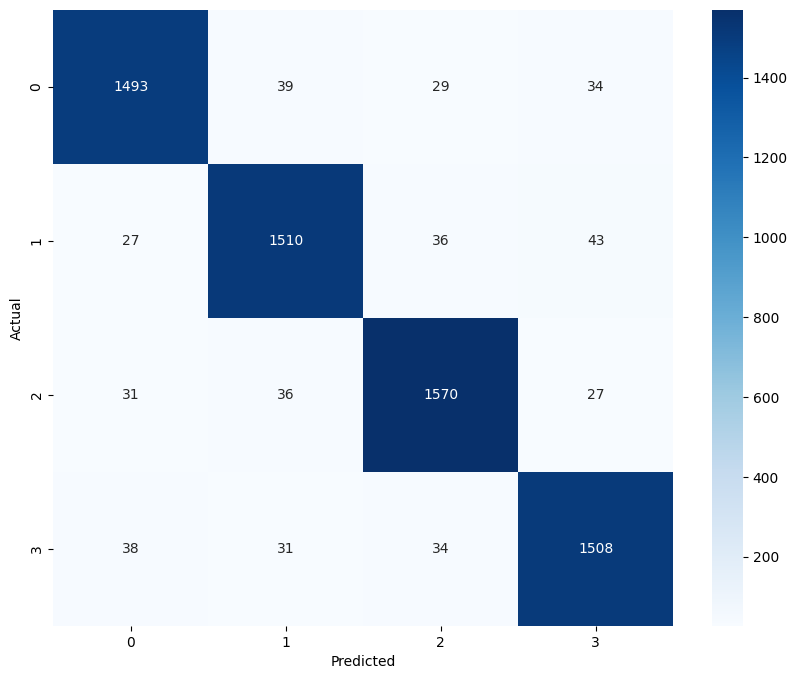

In [176]:
test_example_index = 12 # Change this to test different examples
test_model_on_example(test_df, test_example_index, tokenizer, model3)

predicted_labels_not_trained, correct_labels = test_model_on_dataset(test_df, tokenizer, model3)
#predicted_labels, correct_labels = test_model_on_dataset(test_df, tokenizer, model)

In [178]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to=[]  # Disable Wandb logging
)

for param in model3.bert.parameters():
    param.requires_grad = False

print("Initializing trainer")
trainer = Trainer(
    model=model3,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("Starting training")
trainer.train()

print("Training done")
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print(eval_results)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



Initializing trainer
Starting training


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Training done


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 0.026521440595388412, 'eval_runtime': 183.2851, 'eval_samples_per_second': 35.387, 'eval_steps_per_second': 2.215, 'epoch': 3.0}


Question: What is the adaptive response in NH3 synthesis in the cells of the proximal tubule during chronic acidosis?
Choice 0: Meglitinides are a class of medications that are used to treat type 2 diabetes. They are short-acting drugs that work by stimulating the release of insulin from the pancreas, which helps to lower blood sugar levels. Meglitinides act similarly to another class of diabetes medications called sulfonylureas, as they both work by binding to and activating the ATP-sensitive potassium channels on pancreatic beta cells, leading to insulin secretion. However, meglitinides have a shorter duration of action than sulfonylureas, and are typically taken before meals to help control postprandial blood sugar spikes. Some common examples of meglitinides include repaglinide and nateglinide.
Choice 1: The testes begin to develop in genetic males during gestation at gestational weeks 6 to 7.
Choice 2: In chronic acidosis, there is an adaptive increase in NH3 synthesis in the cell

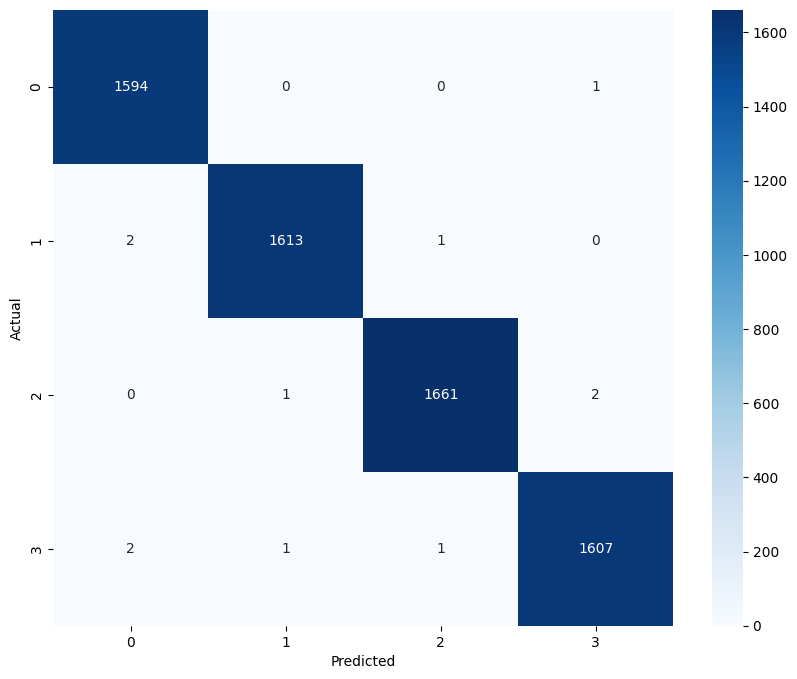

In [179]:
test_example_index = 12 # Change this to test different examples
test_model_on_example(test_df, test_example_index, tokenizer, model3)

predicted_labels_not_trained, correct_labels = test_model_on_dataset(test_df, tokenizer, model3)
#predicted_labels, correct_labels = test_model_on_dataset(test_df, tokenizer, model)

As we can see, the model seems to have learned something, as the accuracy has improved.

### Testing Model 2 using the Multiple Choice Answering from model 3.
 We do this by passing a special instruction to the model telling it to output only a single letter A-D corresponding to the correct option

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

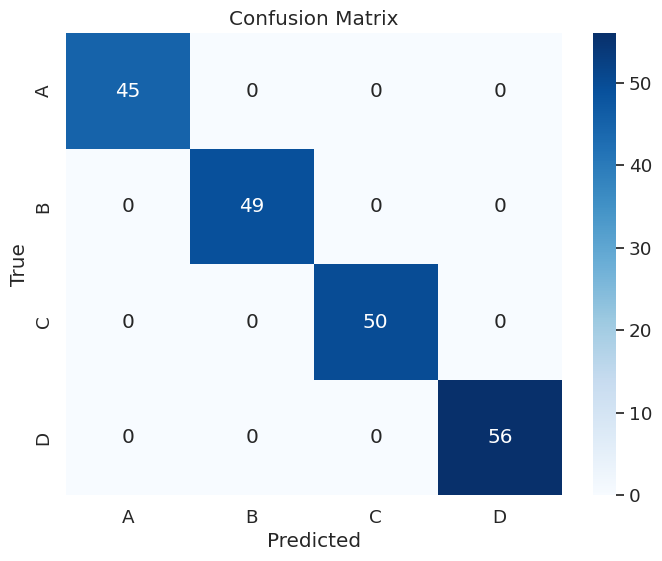

Accuracy:  1.0


In [180]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from datasets import load_dataset

num_choices = 4

# Load the mutiple choice dataset
questions, choices, labels = create_multiple_choice_format(df, num_choices=num_choices)

# Define the size of the subset you want to use
subset_size = 200  # Change this to the desired size of your subset, we use 100 for computational efficiency.

conf_matrix = np.zeros((num_choices, num_choices))
letter_to_label = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
newline_interval = 10
cnt = 0

for i in range(subset_size):
  cnt = cnt + 1
  question = questions[i]
  options = ''
  for j in range(num_choices):
    options = options + ' ' + str(j) + ': ' + choices[i][j]
  target_label = int(labels[i])

  special_instruction="Answer the following questions by writing the number of the correct option. Write nothing but a number: 0, 1, 2, 3 or else bad things will happen:" + options
  pred_label = model2.ask(question=question, special_instruction=special_instruction)
  pred_label = int(pred_label) # This crashes if model doesn't comply. Should add a try/except, but for now the prompting works fine on first 200 samples.

  conf_matrix[target_label, pred_label] += 1

# Plotting the confusion matrix for evaluation
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale

# Plotting the heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print('Accuracy: ', accuracy)

The model has unrealistically promising results. This is likely due to overfitting.

# Trying with more data
We attempted to train model2 on a completely different dataset, and then again on a concatination of the two datasets to see which performs the best on the shuffeling method.


In [181]:
# Loading USMLE data
USMLE_data = load_dataset("GBaker/MedQA-USMLE-4-options")['train'].to_pandas()
# Loading Wikidoc data
wikidoc_data = load_dataset("medalpaca/medical_meadow_wikidoc")['train'].to_pandas()

# Some simple data formatting
USMLE_data = USMLE_data.rename(columns={"question": "input", "answer": "output"})[['input', 'output']]
#wikidoc_data.drop('instruction', axis=1, inplace = True)

df_extra = pd.concat([USMLE_data, wikidoc_data], ignore_index=True) # Concatenate all extra data
df_total = pd.concat([df[['input','output']], df_extra[['input','output']]], ignore_index=True) # Concatenate all available data.

Generating train split:   0%|          | 0/10178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1273 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [182]:
passages_extra = df_extra['output'].tolist()
passages_all = df_total['output'].tolist()

In [183]:
model_extra = DRGAB(passages_extra) # Model for the extra data
# Taking input from the user and storing it in a variable
user_input = "i feel like I'm turning into a werewolf"
response = model_extra.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Loading with device settings: cuda
Computing embeddings


Batches:   0%|          | 0/631 [00:00<?, ?it/s]

Started creating HNSWLIB index


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  i feel like I'm turning into a werewolf
A:  a werewolf


In [184]:
model_total = DRGAB(passages_all) # Model for ALL data
# Taking input from the user and storing it in a variable
user_input = "i feel like I'm turning into a werewolf"
response = model_total.ask(user_input)
print('Q: ', user_input)
print('A: ', response)

Loading with device settings: cuda
Computing embeddings


Batches:   0%|          | 0/1644 [00:00<?, ?it/s]

Started creating HNSWLIB index


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Q:  i feel like I'm turning into a werewolf
A:  a werewolf


### Trying multiple choice model3 on the new data
We try also to test model3 (not retrain) on the completely new data

In [185]:
df_extra = df_extra.drop(columns=['instruction'])
df_extra.head()

input  \
0  A 23-year-old pregnant woman at 22 weeks gesta...   
1  A 3-month-old baby died suddenly at night whil...   
2  A mother brings her 3-week-old infant to the p...   
3  A pulmonary autopsy specimen from a 58-year-ol...   
4  A 20-year-old woman presents with menorrhagia ...   

                                              output  
0                                     Nitrofurantoin  
1  Placing the infant in a supine position on a f...  
2       Abnormal migration of ventral pancreatic bud  
3                                    Thromboembolism  
4                             Von Willebrand disease

In [186]:
df_extra_sample = df_extra.sample(frac=0.2, random_state=42)
print(df_extra_sample.shape)

(4036, 2)


In [187]:
train_df_, val_df_, test_df_, train_dataset_, val_dataset_, test_dataset_ = prepare_dataset_from_dataframe(df_extra_sample, tokenizer)

                                            question  \
0  An investigator studying the epidemiology of b...   
1  A 69-year-old man with type 2 diabetes mellitu...   
2  An 11-year-old boy who recently emigrated from...   
3  A 72-year-old man presents to the physician wi...   
4  A 42-year-old woman is brought to the emergenc...   

                                             choices  label  
0  [If the outcome is ascertained through electro...      1  
1  [Hypercalcemia, The most effective treatment o...      3  
2  [Prematurity Bronchopulmonary Dysplasia Congen...      1  
3  [Treatment is based on the risk stratification...      2  
4  [Transabdominal ultrasonography, A reduced con...      0  


Question: What information can be accessed regarding Sporotrichosis?
Choice 0: Direct immunofluorescence study
Choice 1: Sporotrichosis is typically diagnosed when your doctor obtains a swab or a biopsy of the infected site and sends the sample to a laboratory for a fungal culture. Serological tests are not always useful in the diagnosis of sporotrichosis due to limitations in sensitivity and specificity.
Choice 2: The Global Burden of Disease Study reports a prevalence of 251 million cases of COPD globally in 2016. According to WHO estimates, 65 million people have moderate to severe chronic obstructive pulmonary disease (COPD) worldwide. COPD occurs in 34 out of 1000 greater than 65 years old. In England, an estimated 842,100 of 50 million people have a diagnosis of COPD; translating into approximately one person in 59 receiving a diagnosis of COPD at some point in their lives. In the most socioeconomically deprived parts of the country, one in 32 people were diagnosed with COPD, com

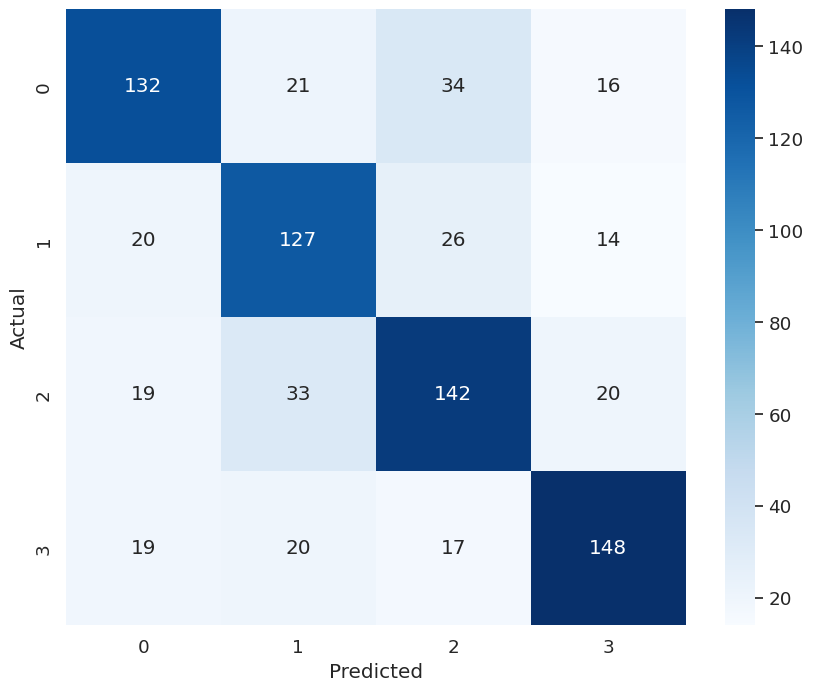

In [188]:
test_example_index = 12 # Change this to test different examples
test_model_on_example(test_df_, test_example_index, tokenizer, model3)

predicted_labels_not_trained, correct_labels = test_model_on_dataset(test_df_, tokenizer, model3)
#predicted_labels, correct_labels = test_model_on_dataset(test_df, tokenizer, model)

A little bit disapointing results, but not awful on a completely unseen dataset with different type of questions. Indicates our model is able to generalise.

Trying model 3 on ALL available data.

                                            question  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   

                                             choices  label  
0  [Glucagon acts on the liver primarily and adip...      1  
1  [Brain natriuretic peptide, Langerhans cells a...      3  
2  [Basiliximab, Low REM sleep latency and experi...      1  
3  [PTH-independent hypercalcemia, which can be c...      0  
4  [During October 1, 2006--May 19, 2007, the WHO...      3  
Question: What is the initial action performed by the supraspinatus muscle on the arm and at what degree range does it occur?
Choice 0: The supraspinatus muscle aBducts the arm initially, from 0 to 15°.
Choice 1: Hypocalcemia may cause heart failure, hypotension, and shock. Hypocalcemia is 

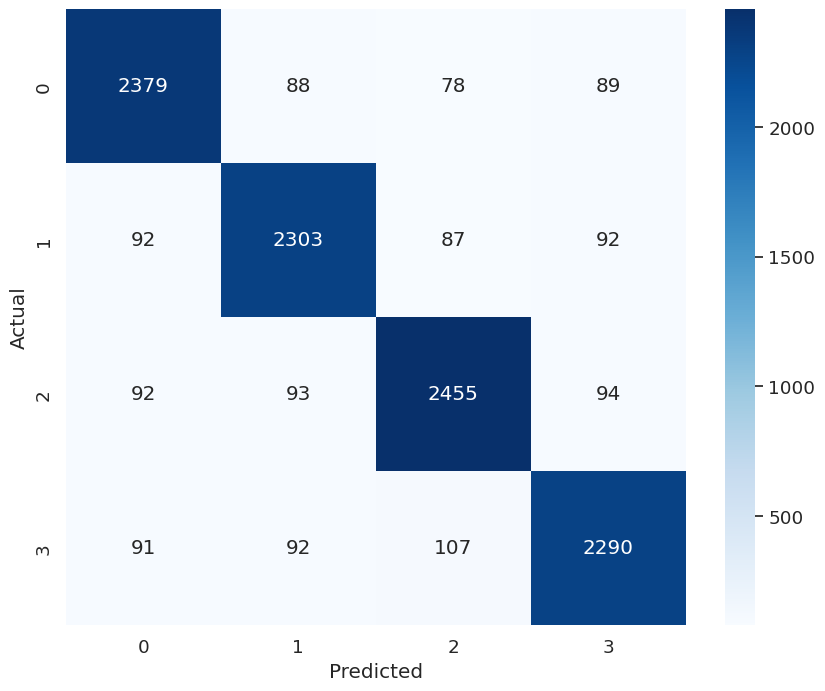

In [189]:
train_df_, val_df_, test_df_, train_dataset_, val_dataset_, test_dataset_ = prepare_dataset_from_dataframe(df_total, tokenizer)
test_example_index = 12 # Change this to test different examples
test_model_on_example(test_df_, test_example_index, tokenizer, model3)

predicted_labels_not_trained, correct_labels = test_model_on_dataset(test_df_, tokenizer, model3)
#predicted_labels, correct_labels = test_model_on_dataset(test_df, tokenizer, model)

It is now better than the extra data, but worse than the original, which is to be expected.

### Things we considered but have not done:
* **Make a disease classifier**:
We would need to modify our dataset such that we can perform simple classification. We could choose the questions that only had 1 word outputs, and clean it manually to get a dataset of diseases.
I fear we have way too little data doing it this way, and will overfit to the moon and back. We will need more data. An idea could be to convert all (feasible) outputs into a single word, using a pre-trained BERT summarizer or something similar. This was deemed not useful enough, and would likely still overfit a classifier with the number of potential classes being so high.

* **Data cleaning**: Cleaning the data further by removing similar inputs. Example of two inputs in our data below.
> 1. "What is the specific type of neurons that undergo degeneration in Parkinson's disease, and where in the basal ganglia does this degeneration occur?"
> 2. What specific type of neurons undergo degeneration in Parkinson's disease, and in which region of the basal ganglia does this degeneration occur?"

  We faced too much computational problems calculating the Levenschtein-distances, as the distance matrix would be of the order of a billion. We also felt we were already lacking data, and maybe having reformulations would help our model generalize better and understand the meaning of the inputs independently of word order.

* **Match the input to input-data instead of output data**: Our original model matches the user-input to an output in the dataset with BM25, but an idea could be to match the user-input to an input in the dataset, and then using the associated output from the one-to-one mapping. We did not explore this as it was very hard to validate or compare. We also hypothise this option would be worse, as the inputs are generally shorter, and the levenschtein distances would be shorter, leading to worse generalization.